In [4]:
import pandas as pd
import numpy as np
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws

from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)

import braindecode
braindecode.__version__

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['AFz', 'Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz', 'Iz']
chan_others = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\_MOT_BCI_\\src\\'
directory_data = 'D:\\PhD\\_MOT_BCI_\\data - raw\\'
directory_preproc = 'D:\\PhD\\_MOT_BCI_\\data - preprocessed\\'

In [299]:
filepath = directory_data + 'W10F2.bdf' #'F12F2.bdf' #'T25F1.bdf' #'W10F2.bdf'
raw = read_raw_bdf(filepath, preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Downsampling
raw.resample(256)
# Filter
raw = raw.filter(4, 40)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

# Load Behav Data.
df_behav = pd.read_csv(filepath[:filepath.rfind('.')] + '.csv', sep=',')

# Rework Events based on Behav Data. (to add Side and SetSize information)
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        #if (nb_trials + 1) % 10 == 0:
            #print('Check Synch!')

# Working with modified events from now on.
events = new_events

# Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
print('==================================================')
print('Removing Events ID not in EEG File...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================') 

Extracting EDF parameters from D:\PhD\_MOT_BCI_\data - raw\W10F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6434815  =      0.000 ...  3142.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband

In [300]:
raw = mne.set_bipolar_reference(raw, anode=chan_left_all, cathode=chan_right_all, verbose=False)

# Remove midline and others channels
rm_list = chan_others + chan_midline_all
keep_ch = [ch for ch in raw.info['ch_names'] if ch not in rm_list]
raw = raw.pick_channels(keep_ch)

<RawEDF | W10F2.bdf, 27 x 804352 (3142.0 s), ~165.7 MB, data loaded>

In [305]:
print(raw.info['sfreq'])
print(raw.info['ch_names'])

256.0
['O1-O2', 'PO3-PO4', 'PO7-PO8', 'P1-P2', 'P3-P4', 'P5-P6', 'P7-P8', 'P9-P10', 'C1-C2', 'C3-C4', 'C5-C6', 'CP1-CP2', 'CP3-CP4', 'CP5-CP6', 'T7-T8', 'TP7-TP8', 'FT7-FT8', 'FC1-FC2', 'FC3-FC4', 'FC5-FC6', 'F1-F2', 'F3-F4', 'F5-F6', 'F7-F8', 'AF3-AF4', 'AF7-AF8', 'Fp1-Fp2']


In [303]:
ml_event_id = dict()
ml_event_id['ml_left'] = 1
ml_event_id['ml_right'] = 0

new_merged_events = mne.merge_events(events, [121, 221, 321], ml_event_id['ml_left']) # Only Good for now.
new_merged_events = mne.merge_events(new_merged_events, [111, 211, 311], ml_event_id['ml_right'])  # Only Good for now.

ml_events = new_merged_events[(new_merged_events[:,2] == 0) | (new_merged_events[:,2] == 1)]
#ml_events

ml_anns = mne.annotations_from_events(ml_events, raw.info['sfreq'])
#ml_anns

raw.set_annotations(ml_anns)
raw.annotations

<Annotations | 45 segments: 0 (21), 1 (24)>

# Approach No.1 - BrainDecode Datasets

In [306]:
from braindecode.datasets.base import BaseDataset, BaseConcatDataset
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess

base_set = BaseDataset(raw)
dataset = BaseConcatDataset([base_set])
                       
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    MNEPreproc(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    NumpyPreproc(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
#preprocess(dataset, preprocessors)

C:\Users\Yannick\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:67: FutureWarning: Class MNEPreproc is deprecated; will be removed in 0.7.0. Use Preprocessor with `apply_on_array=False` instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Yannick\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:67: FutureWarning: Class NumpyPreproc is deprecated; will be removed in 0.7.0. Use Preprocessor with `apply_on_array=True` instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Yannick\Miniconda3\lib\site-packages\braindecode\preprocessing\preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [307]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

window_size_samples = int(sfreq * 1)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset, 
    trial_start_offset_samples=0, 
    trial_stop_offset_samples=window_size_samples,
    #window_size_samples=window_size_samples,
    #window_stride_samples=1, 
    preload=True)#, 
    #mapping=mapping)

Used Annotations descriptions: ['0', '1']
Adding metadata with 4 columns
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 255 original time points ...
0 bad epochs dropped


In [308]:
X = windows_dataset.datasets[0].windows.get_data()
y = np.array(windows_dataset.datasets[0].y)
print(X.shape)
print(y.shape)

X_test = X[40:45, :, :]
y_test = y[40:45]

X_train = X[0:40, : , :]
y_train = y[0:40]

(45, 27, 255)
(45,)


Text(0.5, 0, 'Timesteps')

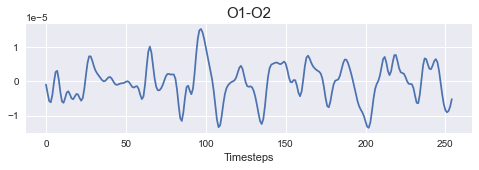

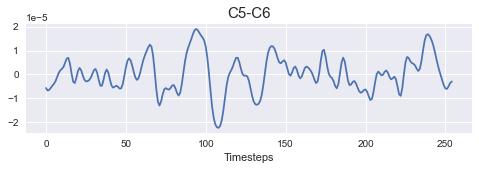

In [309]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0][0])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[0]}", fontsize=15)
plt.xlabel("Timesteps")
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0][10])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[10]}", fontsize=15)
plt.xlabel("Timesteps")

C:\Users\Yannick\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


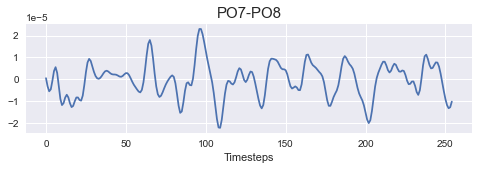

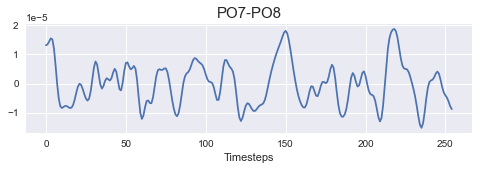

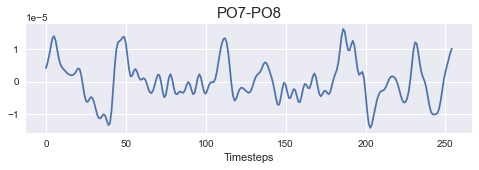

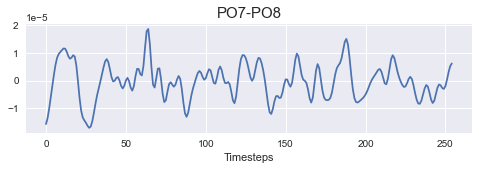

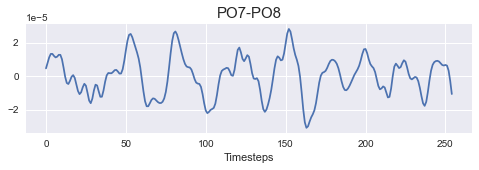

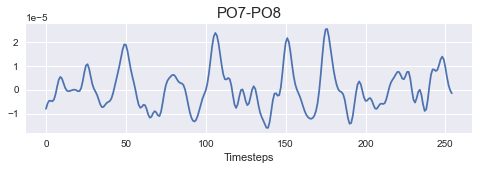

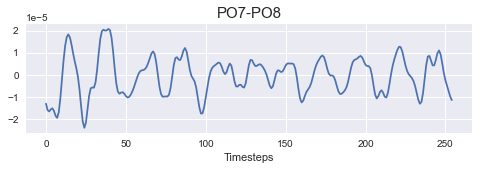

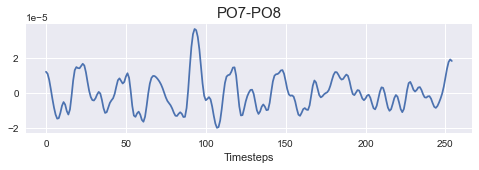

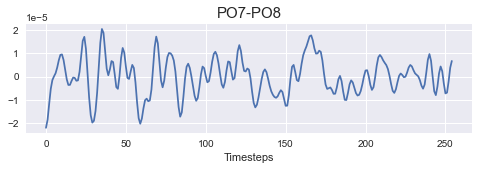

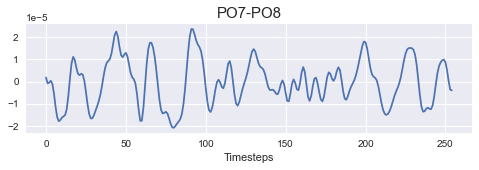

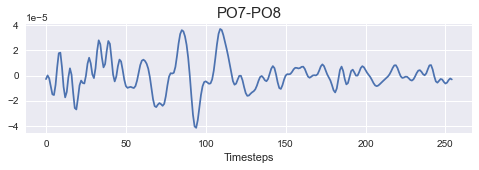

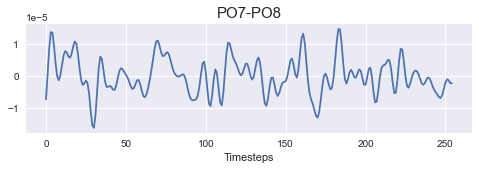

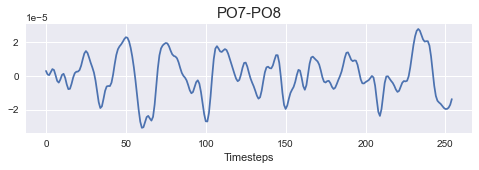

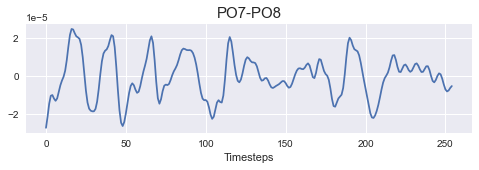

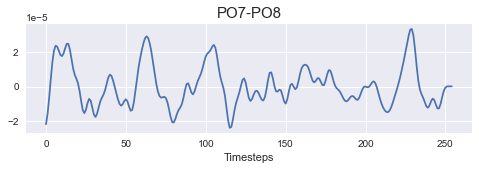

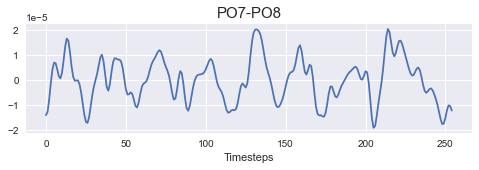

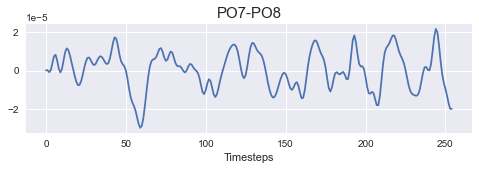

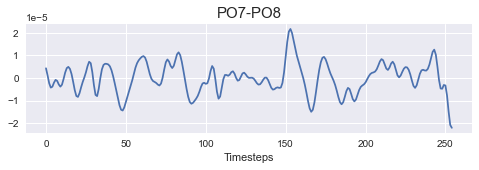

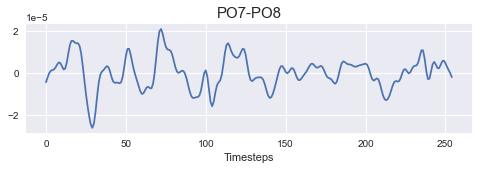

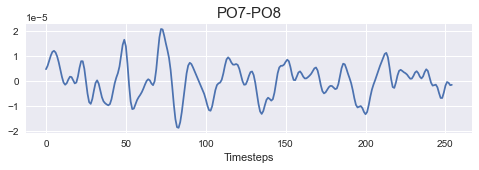

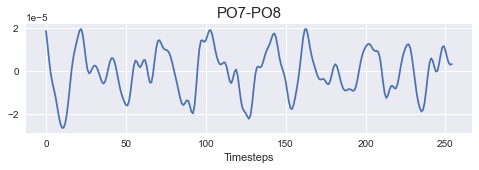

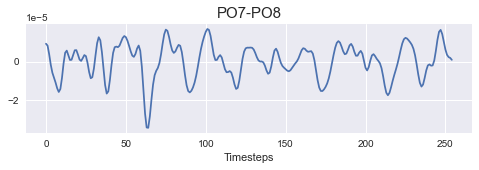

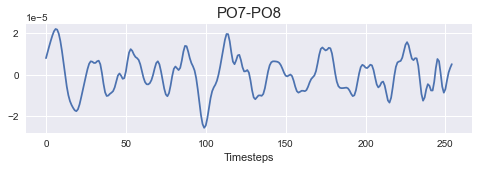

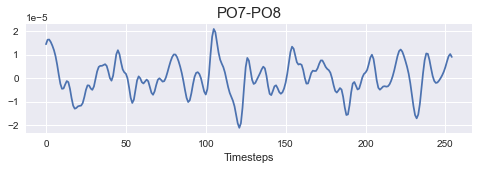

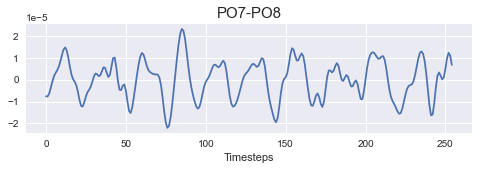

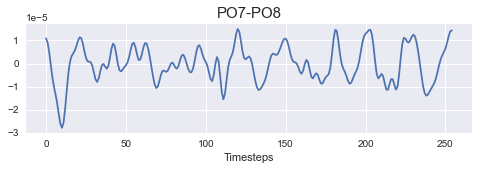

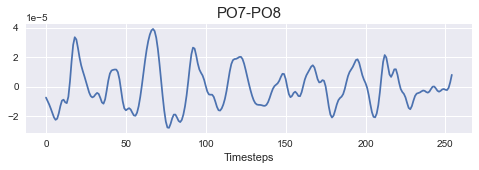

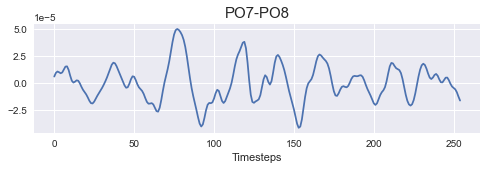

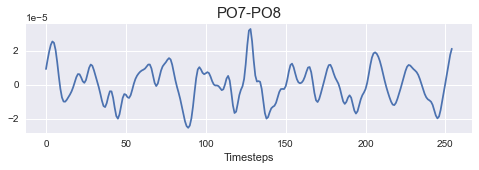

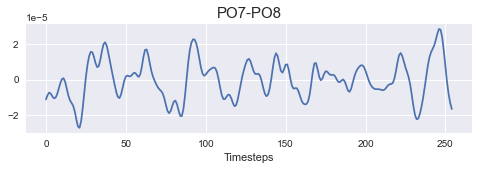

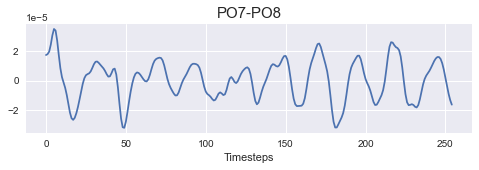

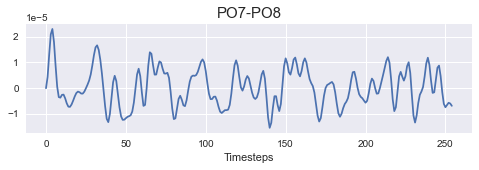

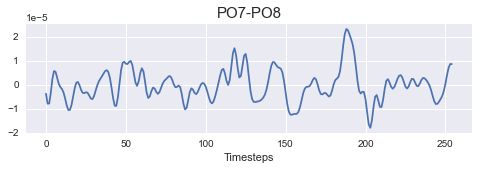

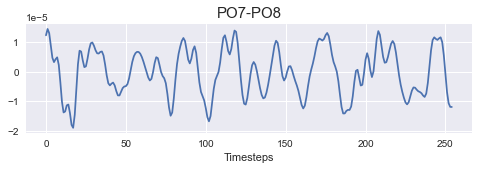

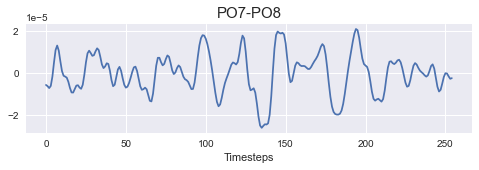

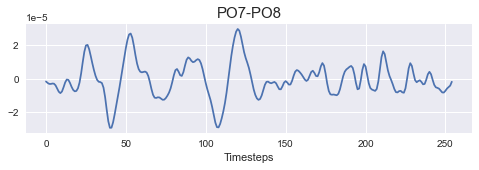

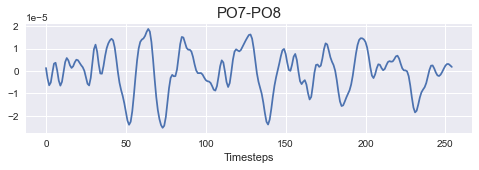

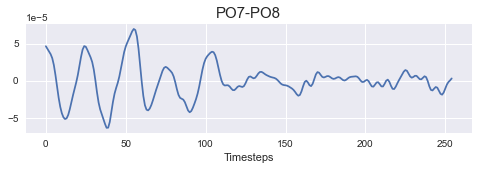

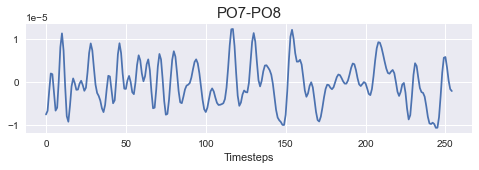

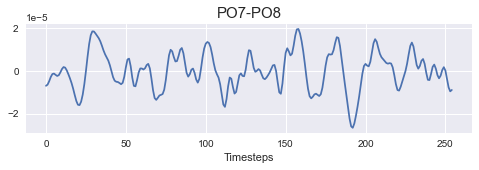

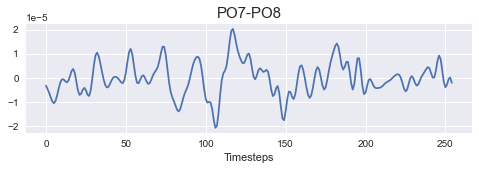

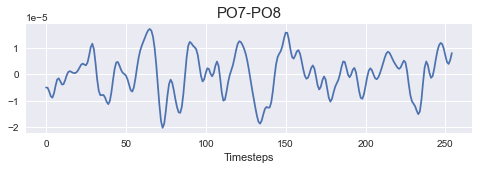

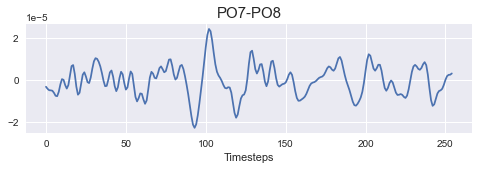

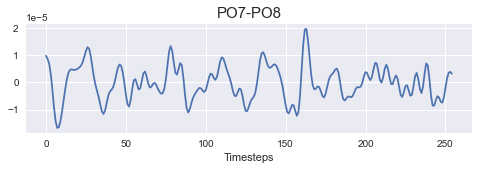

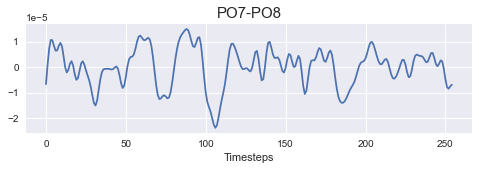

In [312]:
ch_id = 2
for trial in range(X.shape[0]):
    plt.figure(figsize=(8,2))
    plt.style.use('seaborn')
    plt.plot(X[trial][ch_id])
    plt.title(f"{windows_dataset.datasets[0].windows.ch_names[ch_id]}", fontsize=15)
    plt.xlabel("Timesteps")

In [288]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
# Extract number of chans and time steps from dataset
n_chans = 64 #train_set[0][0].shape[0]
input_window_samples = 1200 #train_set[0][0].shape[1]

model = ShallowFBCSPNet( #EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

In [289]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from skorch.dataset import ValidSplit

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0.0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 4
n_epochs = 8

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=ValidSplit(5), #predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)

clf.fit(X[0:40,:,:], y=y[0:40], epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.6875        1.3878            0.5000        1.3797  0.0006  1.6839
      2            0.8438        0.8726            0.2500        1.6600  0.0006  1.6852
      3            0.9375        0.6240            0.3750        1.7998  0.0005  1.6821
      4            0.9375        0.1356            0.3750        1.6578  0.0004  1.7363
      5            1.0000        0.0956            0.3750        1.5705  0.0002  1.7437
      6            1.0000        0.1375            0.3750        1.6042  0.0001  1.7476
      7            1.0000        0.3199            0.3750        1.6282  0.0000  1.7133
      8            1.0000        0.1987            0.3750        1.6326  0.0000  1.6911


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 64), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 2, kernel_size=(74, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

In [263]:
clf.predict(X_temp)

RuntimeError: Calculated padded input size per channel: (1 x 64). Kernel size: (25 x 1). Kernel size can't be greater than actual input size

In [262]:
X_temp = X[41,:,:]
X_temp = X_temp.reshape(2048, 64)

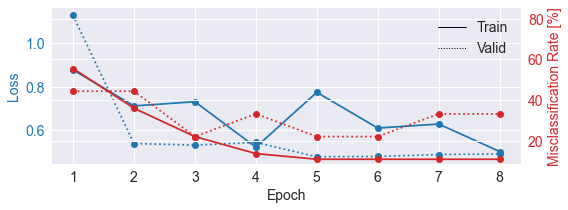

In [181]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

# 2nd Approach with Data and Labels directly epoched!

In [203]:
# Epoching
epochs = Epochs(raw, ml_events, event_id=ml_event_id, tmin=0.15, tmax=1.15, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

epochs_bipolar = mne.set_bipolar_reference(epochs, anode=chan_left_all, cathode=chan_right_all, verbose=False)
epochs_id = epochs_bipolar.copy().crop(tmin=0.15, tmax=1.15)

Not setting metadata
45 matching events found
Setting baseline interval to [0.1484375, 1.1484375] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 257 original time points ...
0 bad epochs dropped


<ipython-input-203-3834f7181296>:5: RuntimeWarning: tmax is not in epochs time interval. tmax is set to epochs.tmax
  epochs_id = epochs_bipolar.copy().crop(tmin=0.15, tmax=1.15)


In [204]:
# Convert data from volt to millivolt
# Pytorch expects float32 for input and int64 for labels.
X = (epochs_id.get_data() * 1e6).astype(np.float32)
y = (epochs_id.events[:,2]).astype(np.int64)

X.shape

(45, 37, 257)

In [205]:
from braindecode.datautil import create_from_X_y

sfreq = epochs_id.info['sfreq']
ch_names = epochs_id.info['ch_names']

windows_dataset = create_from_X_y(
    X[:35], y[:35], drop_last_window=True, sfreq=sfreq, ch_names=ch_names,
    window_stride_samples=2,
    window_size_samples=256,
)

windows_dataset.description  # look as dataset description

Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.
Creating RawArray with float64 data, n_channels=37, n_times=257
    Range : 0 ... 256 =      0.000 ...     1.000 secs
Ready.


C:\Users\Yannick\Miniconda3\lib\site-packages\braindecode\datautil\__init__.py:15: UserWarning: create_from_X_y has been moved to datasets, please use from braindecode.datasets import create_from_X_y
  warn('create_from_X_y has been moved to datasets, please use from braindecode.datasets import create_from_X_y')


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 256 original time points ...
0 bad epochs dro

target
0        0
1        0
2        1
3        0
4        1
5        0
6        1
7        0
8        1
9        1
10       1
11       0
12       0
13       1
14       0
15       1
16       1
17       1
18       0
19       1
20       0
21       0
22       0
23       1
24       1
25       1
26       0
27       0
28       1
29       0
30       0
31       1
32       0
33       1
34       0

In [206]:
i = 0
x_i, y_i, window_ind = windows_dataset[0]
n_channels, n_times = x_i.shape  # the EEG data
_, start_ind, stop_ind = window_ind
print(f"n_channels={n_channels}  -- n_times={n_times} -- y_i={y_i}")
print(f"start_ind={start_ind} -- stop_ind={stop_ind}")

Using data from preloaded Raw for 1 events and 256 original time points ...
n_channels=37  -- n_times=256 -- y_i=0
start_ind=0 -- stop_ind=256


In [207]:
splitted = windows_dataset.split([list(range(0, 30)), list(range(25, 30))])
train_set = splitted['1']
valid_set = splitted['0']

In [208]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...


In [209]:
train_set[0][0].shape[1]

Using data from preloaded Raw for 1 events and 256 original time points ...


256

In [210]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 8

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data f

Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data f

Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data f

Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
Using data from preloaded Raw for 1 events and 256 original time points ...
      8            1.0000        0.0112            0.5333        0.8404  0.0000  0.1620


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 37), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 2, kernel_size=(11, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

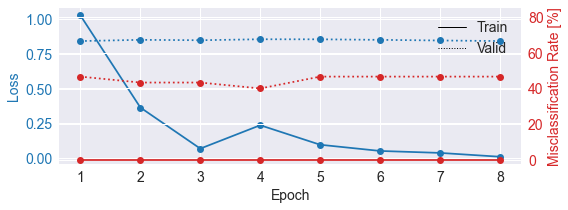

In [211]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

Text(0.5, 0, 'Timesteps')

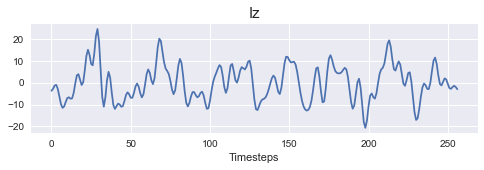

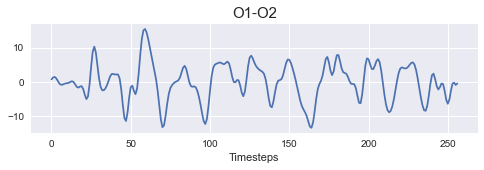

In [212]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0][1])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[0]}", fontsize=15)
plt.xlabel("Timesteps")
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0][10])
plt.title(f"{windows_dataset.datasets[0].windows.ch_names[10]}", fontsize=15)
plt.xlabel("Timesteps")

# Look at Data: ~30-50 Epochs / Trials

In [327]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['AFz', 'Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz', 'Iz']
chan_others = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\_MOT_BCI_\\src\\'
directory_data = 'D:\\PhD\\_MOT_BCI_\\data - raw\\'
directory_preproc = 'D:\\PhD\\_MOT_BCI_\\data - preprocessed\\'

filepath = directory_data + 'T25F1.bdf' #'W10F2.bdf' #'F12F2.bdf' #'T25F1.bdf'
raw = read_raw_bdf(filepath, preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Downsampling
raw.resample(256)
# Filter
raw = raw.filter(4, 40)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

# Load Behav Data.
df_behav = pd.read_csv(filepath[:filepath.rfind('.')] + '.csv', sep=',')

# Rework Events based on Behav Data. (to add Side and SetSize information)
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        #if (nb_trials + 1) % 10 == 0:
            #print('Check Synch!')

# Working with modified events from now on.
events = new_events

# Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
print('==================================================')
print('Removing Events ID not in EEG File...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================') 

Extracting EDF parameters from D:\PhD\_MOT_BCI_\data - raw\T25F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065599  =      0.000 ...  3450.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband

In [328]:
# Epoching
epochs = Epochs(raw, events, event_id=cur_event_id, tmin=11, tmax=12.5, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')
epochs_bipolar = mne.set_bipolar_reference(epochs, anode=chan_left_all, cathode=chan_right_all, verbose=False)
#epochs_id = epochs_bipolar.copy().crop(tmin=0.15, tmax=1.15)


Not setting metadata
84 matching events found
Setting baseline interval to [11.0, 12.5] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 385 original time points ...
0 bad epochs dropped


In [333]:
# Remove midline and others channels
rm_list = chan_others + chan_midline_all
keep_ch = [ch for ch in epochs_bipolar.info['ch_names'] if ch not in rm_list]
epochs_bipolar = epochs_bipolar.pick_channels(keep_ch)

for ch_pair in epochs_bipolar.ch_names:
    print(ch_pair)
    x = epochs_bipolar['right'].copy().pick_channels([ch_pair]).average().plot()

O1-O2


TypeError: pick_channels() missing 1 required positional argument: 'ch_names'

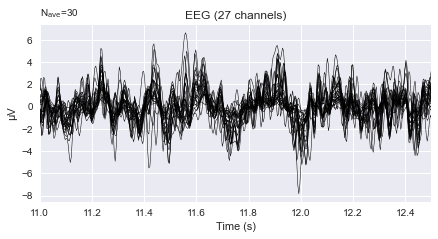

In [335]:
x = epochs_bipolar['left'].copy().average().plot()

# For All Subjects - ERPs

Processing: F12F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

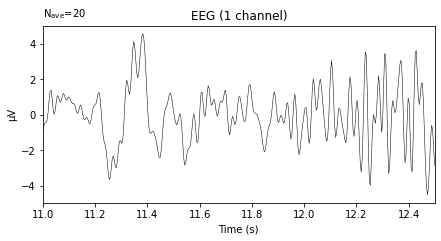

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


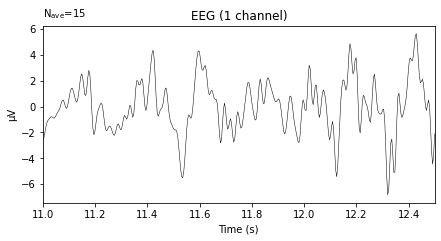

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


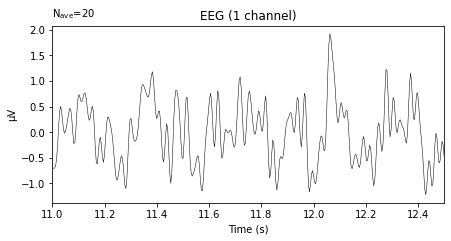

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


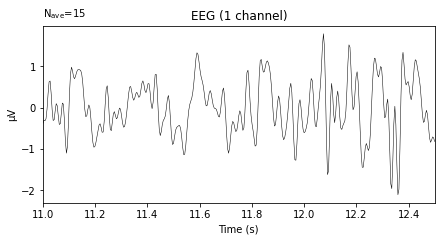

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


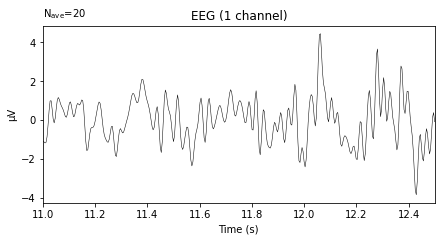

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


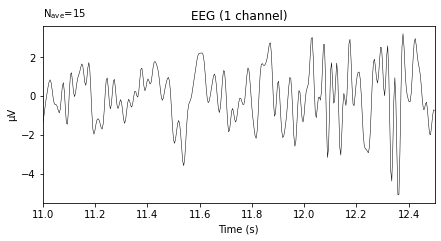

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


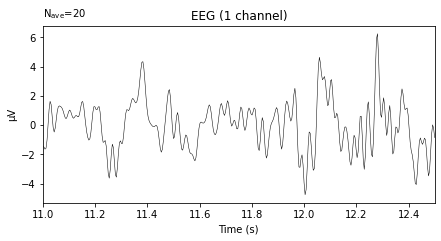

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


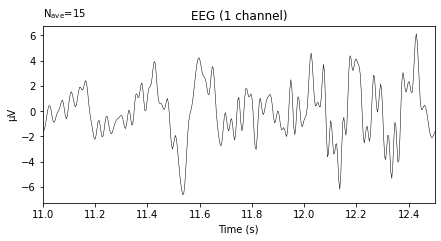

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


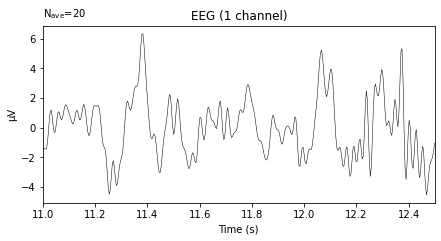

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


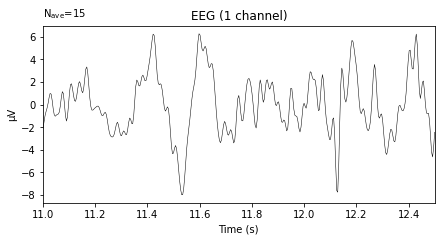

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


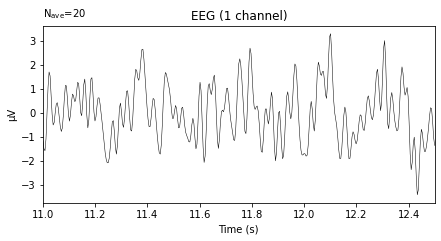

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


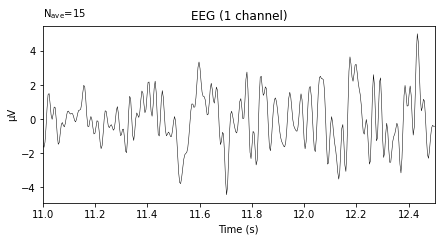

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


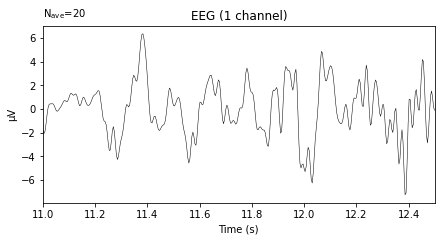

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


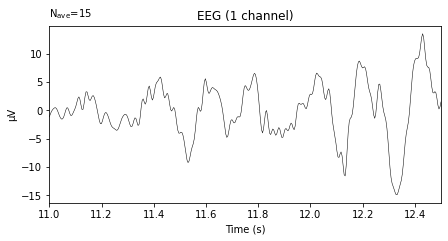

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


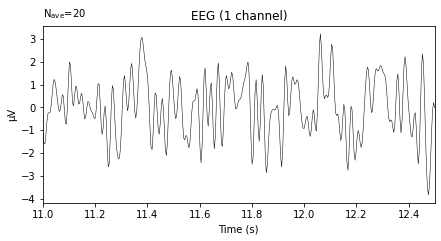

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


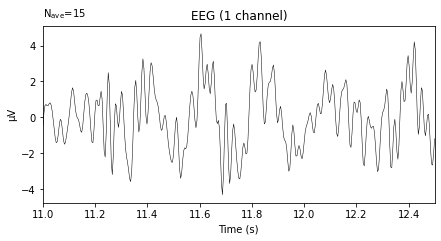

Processing: F12M1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

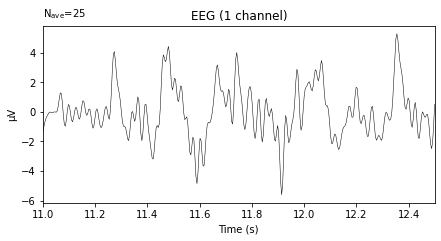

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


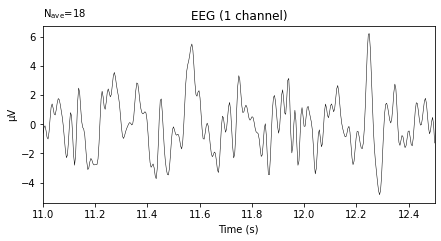

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


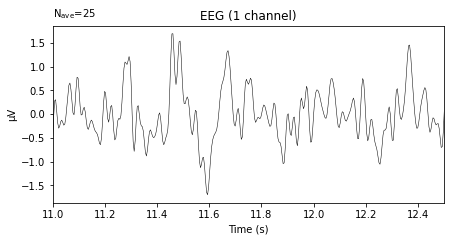

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


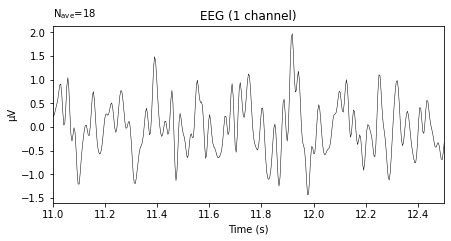

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


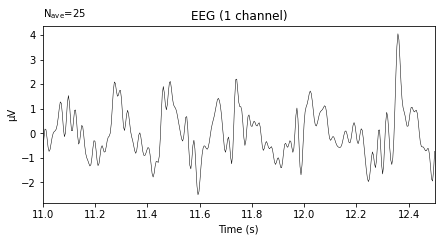

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


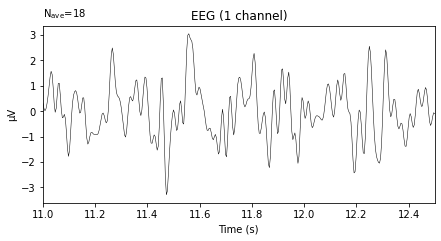

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


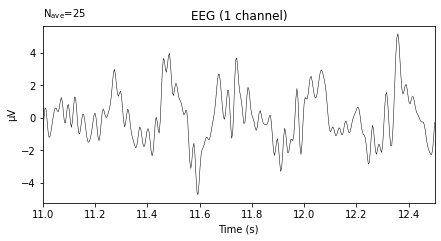

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


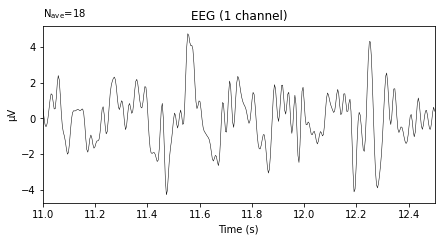

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


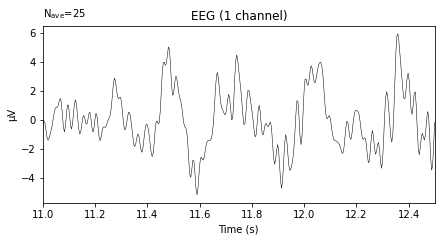

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


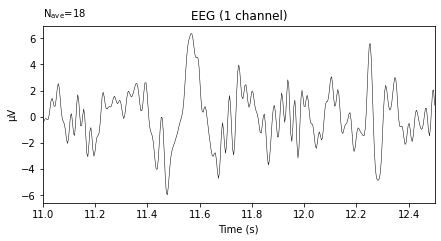

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


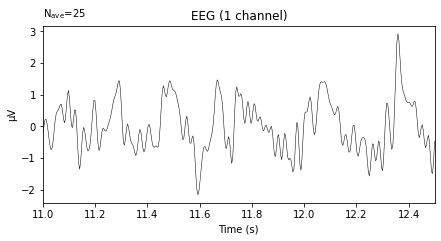

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


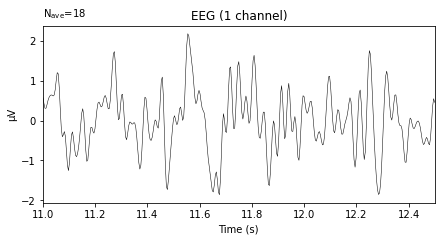

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


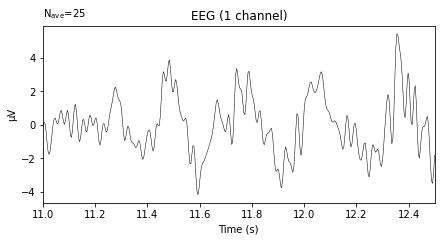

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


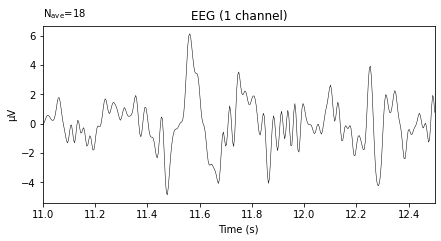

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


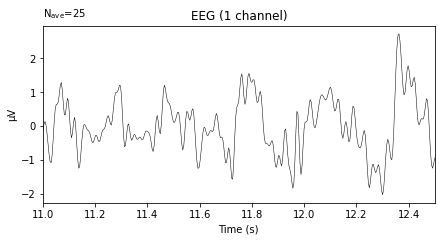

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


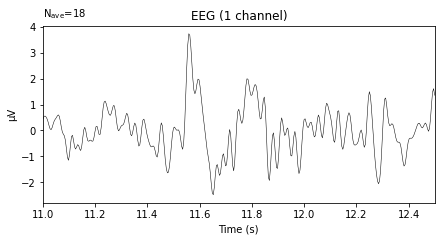

Processing: F19M1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

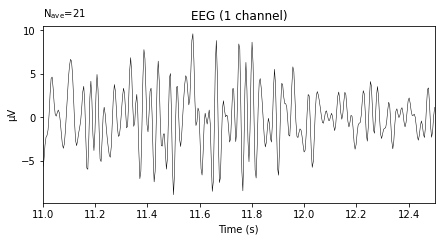

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


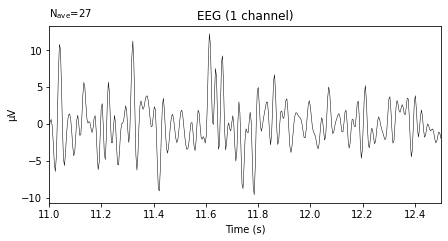

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


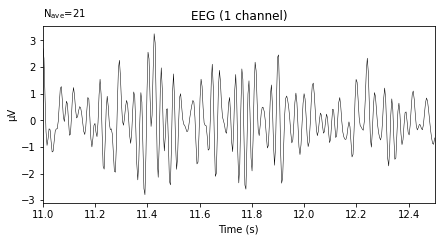

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


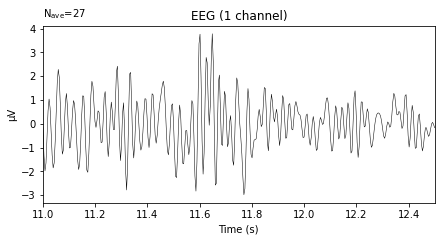

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


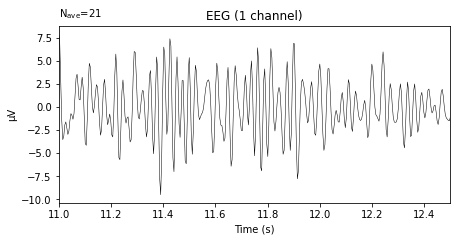

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


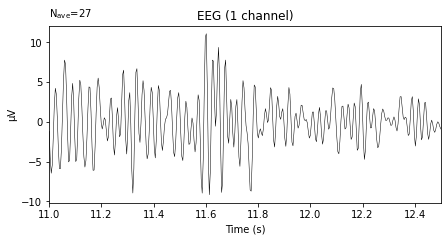

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


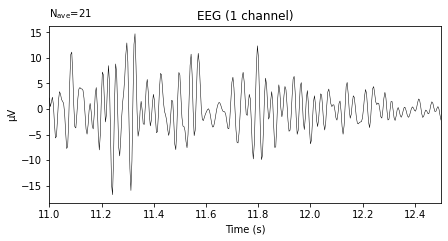

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


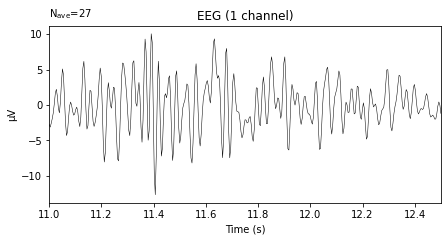

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


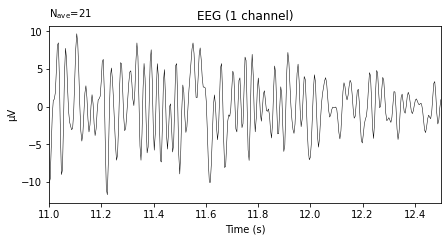

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


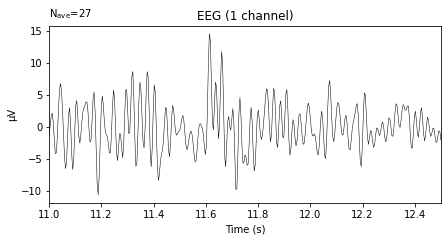

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


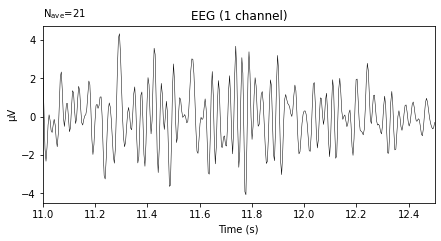

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


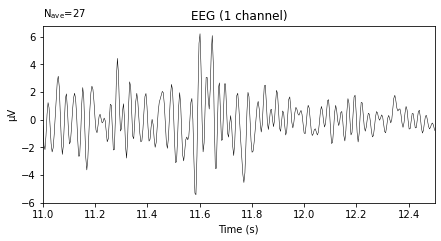

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


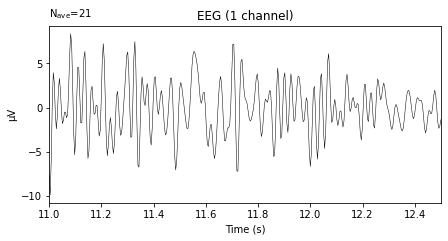

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


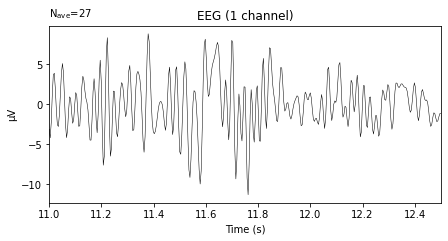

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


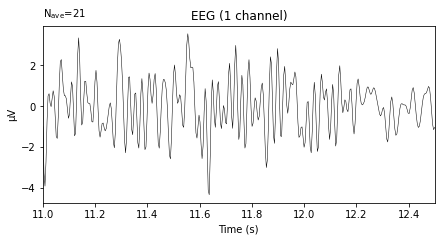

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


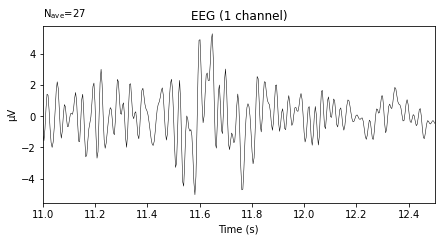

Processing: F26F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
237 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
237 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

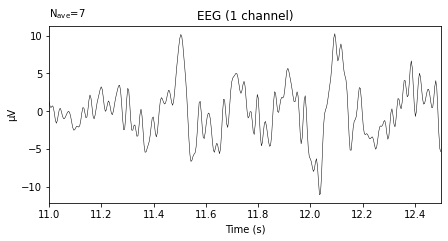

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


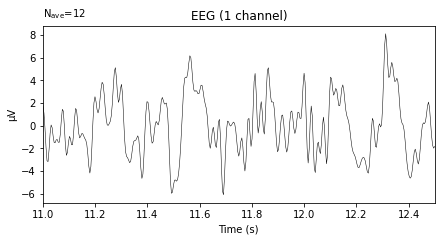

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


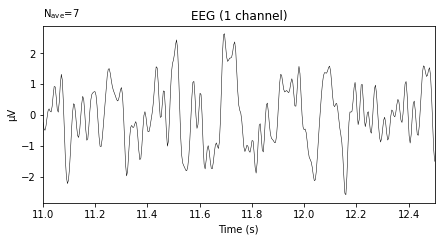

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


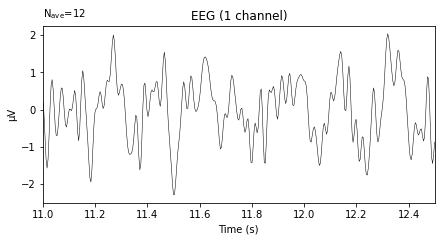

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


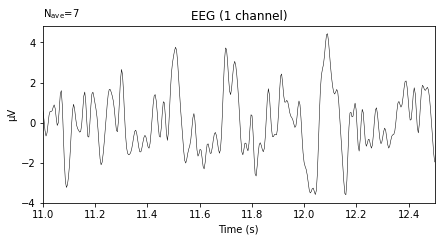

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


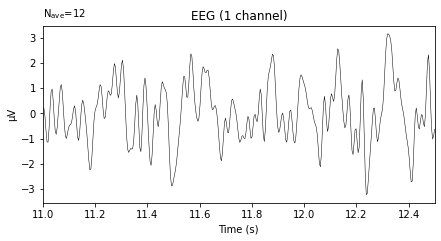

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


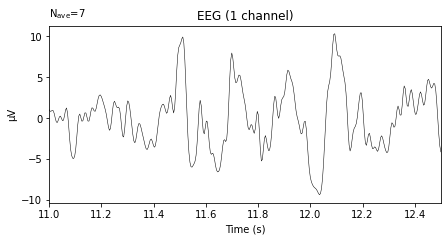

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


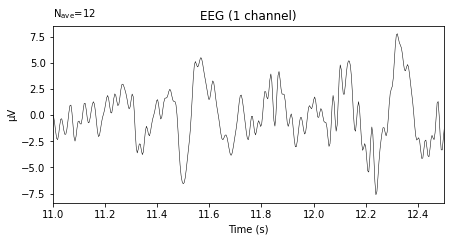

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


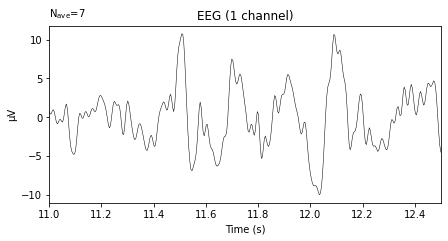

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


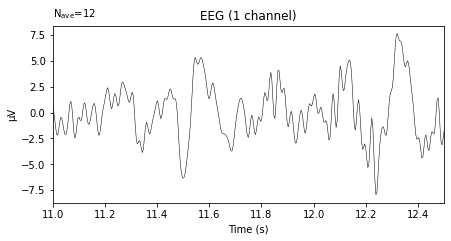

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


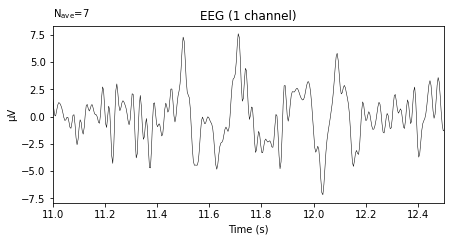

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


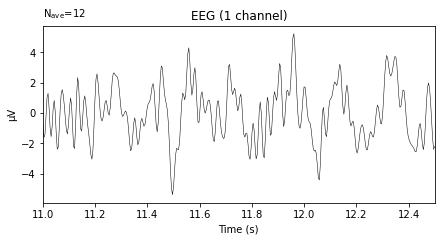

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


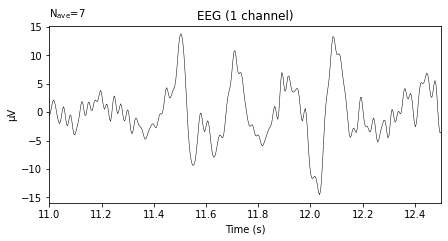

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


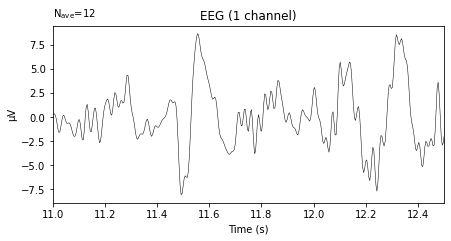

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


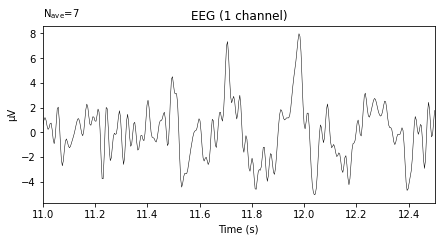

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


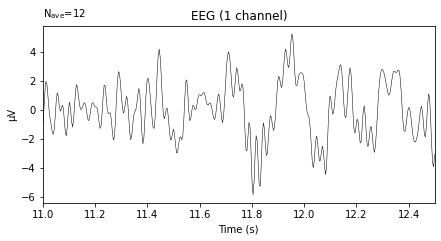

Processing: F5M1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
258 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
258 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition

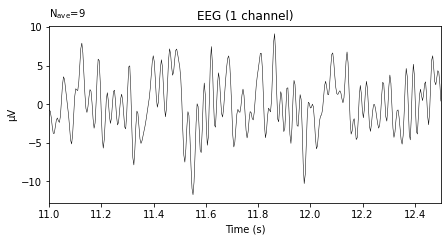

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


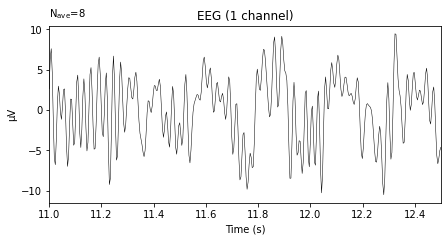

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


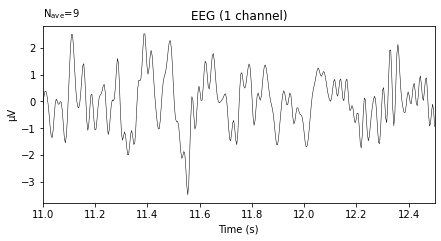

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


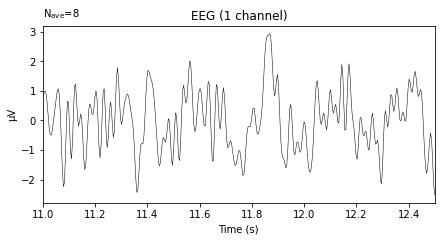

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


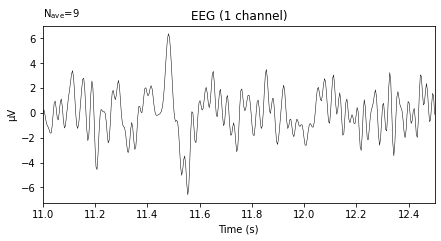

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


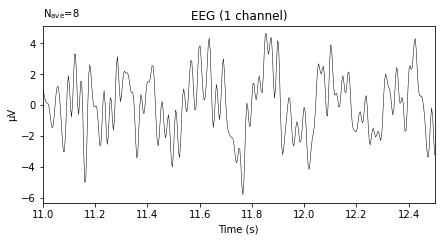

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


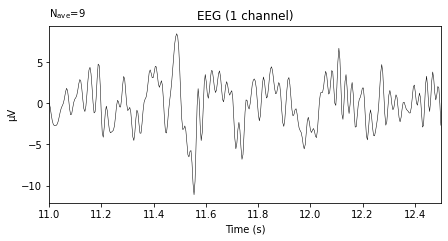

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


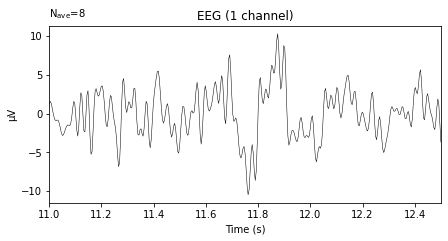

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


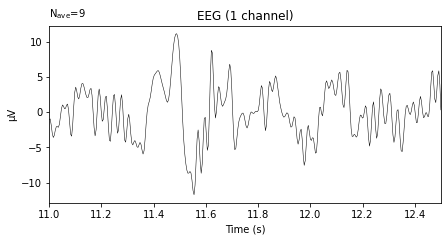

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


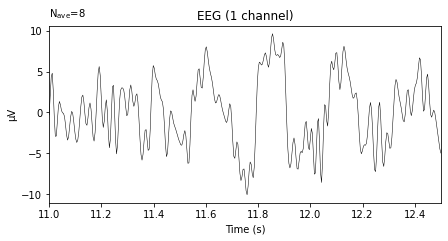

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


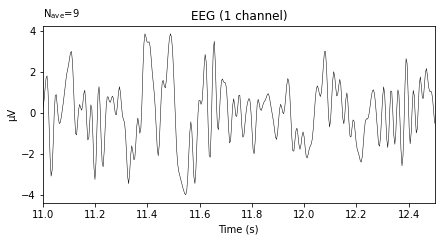

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


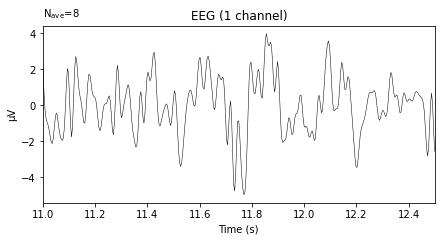

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


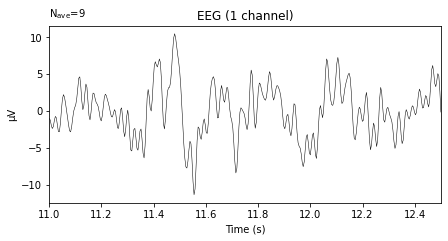

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


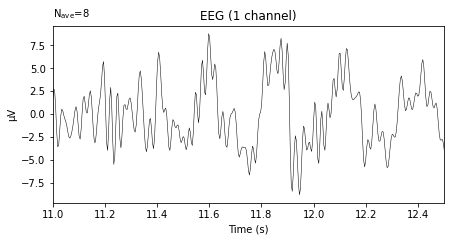

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


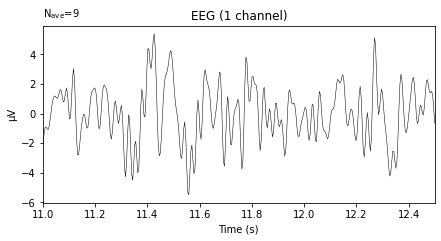

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


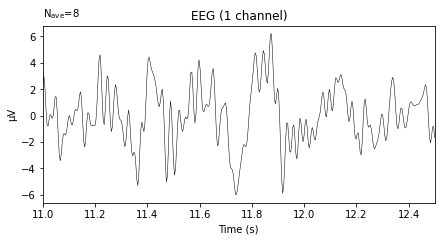

Processing: M22F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (1.652 sec)

516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Not setting metadata
84 matching events found
Setting baseline interval to [11.0, 12.5] sec
Applying baseline

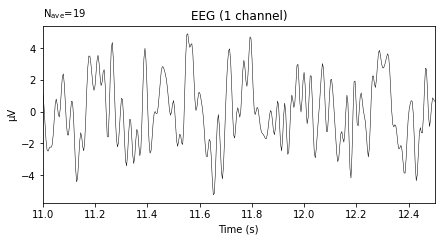

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


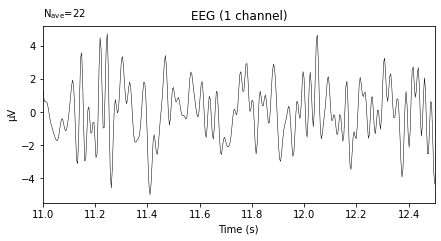

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


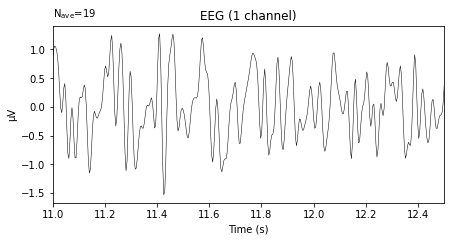

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


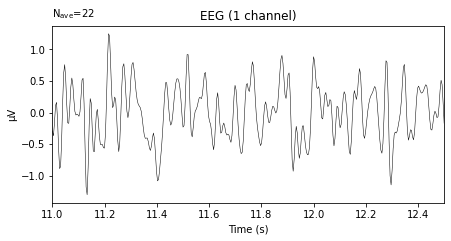

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


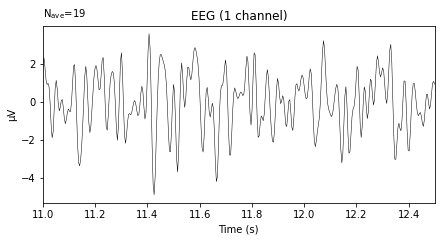

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


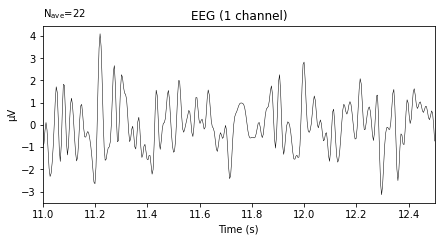

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


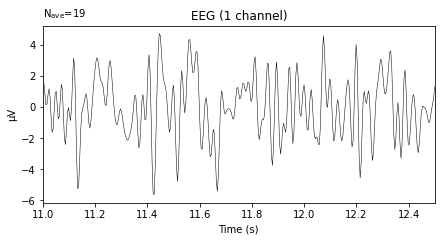

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


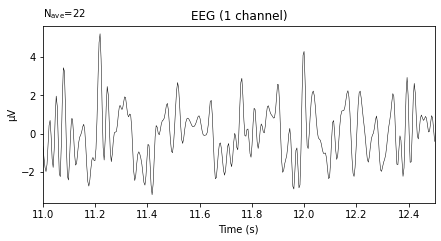

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


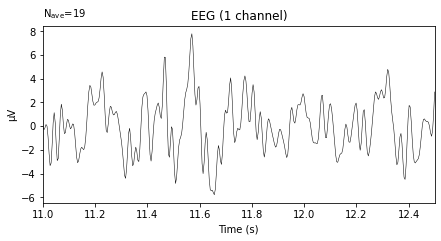

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


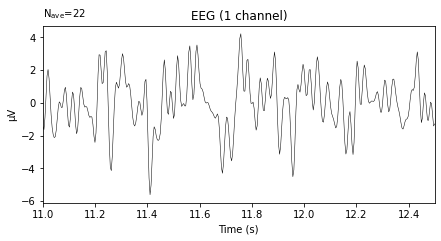

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


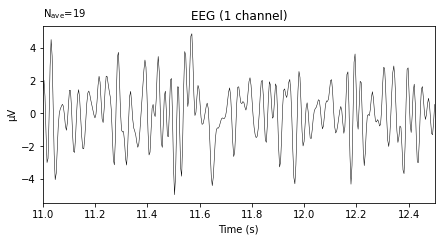

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


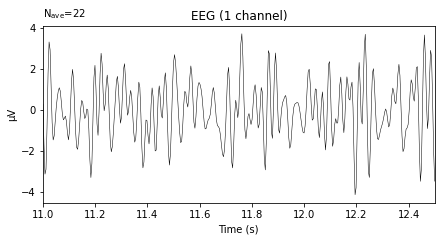

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


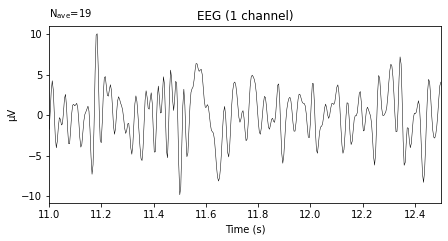

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


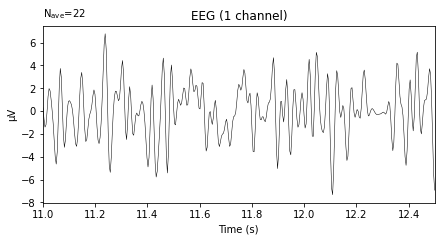

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


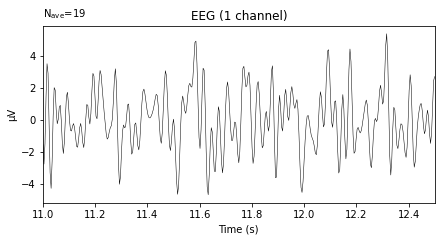

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


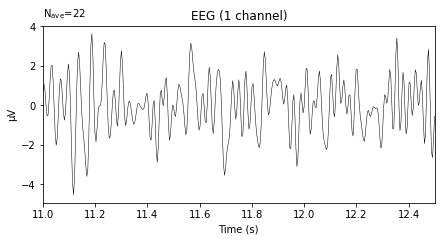

Processing: M8M1_B1-B2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
645 events found
Event IDs: [    1     2     4     8    16    32 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
645 events found
Event IDs: [    1     2     4     8    16    32 65536]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00

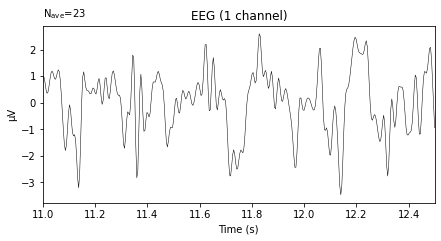

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


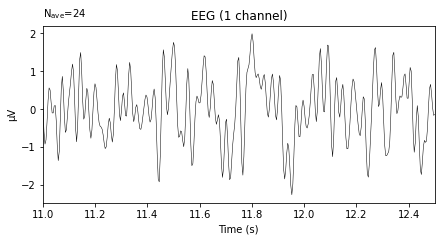

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


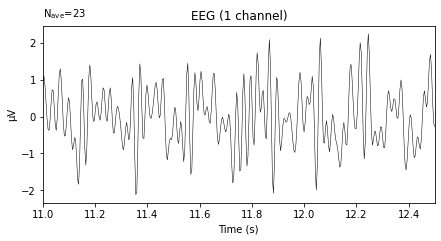

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


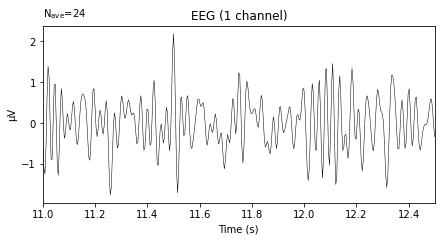

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


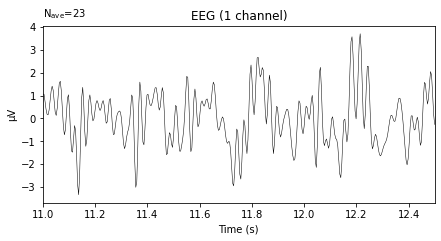

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


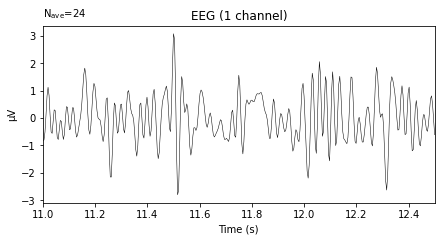

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


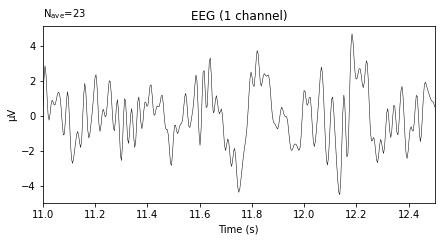

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


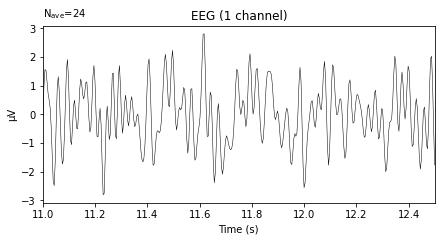

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


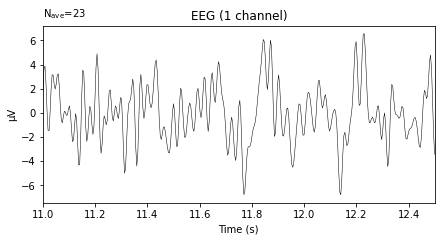

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


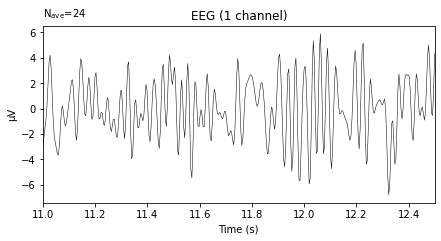

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


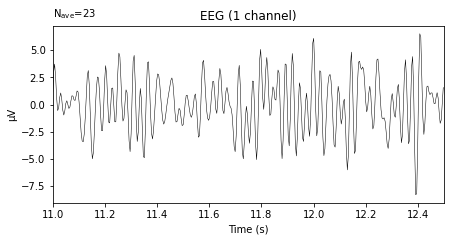

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


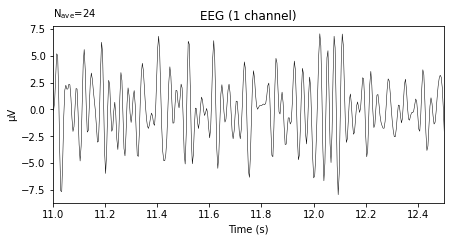

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


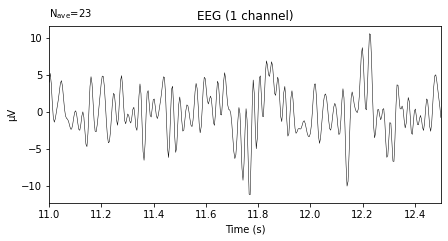

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


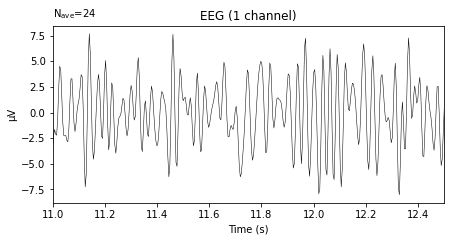

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


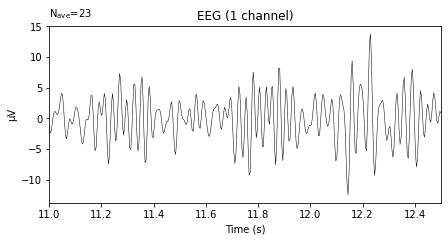

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


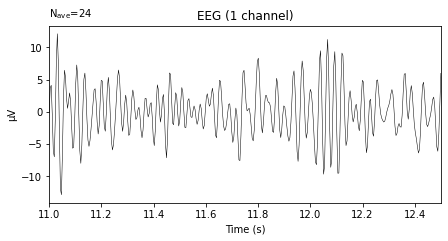

Processing: M8M2_B1-B2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
518 events found
Event IDs: [    1     2     4     8    16    32 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
518 events found
Event IDs: [    1     2     4     8    16    32 65536]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00

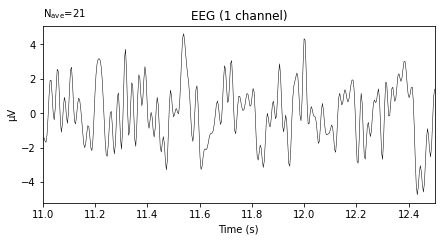

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


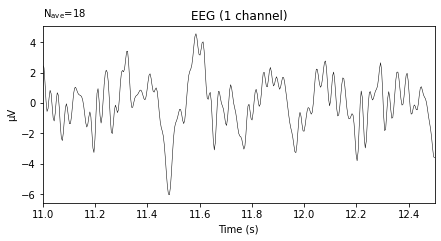

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


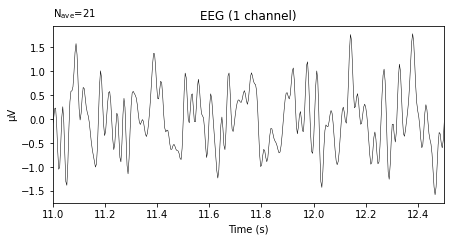

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


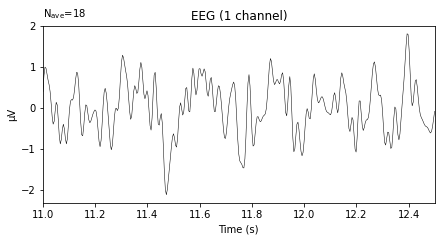

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


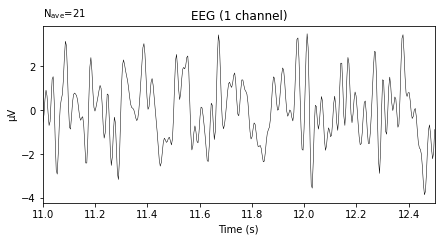

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


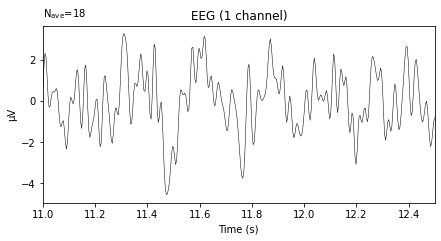

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


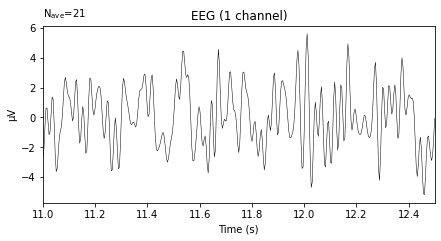

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


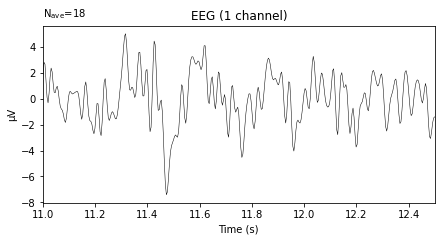

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


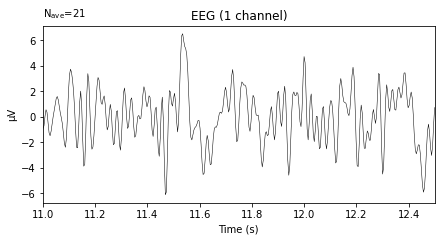

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


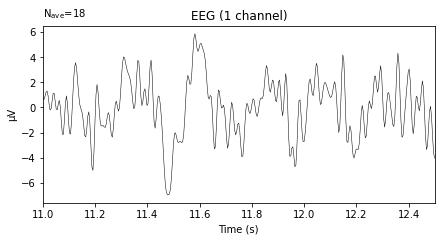

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


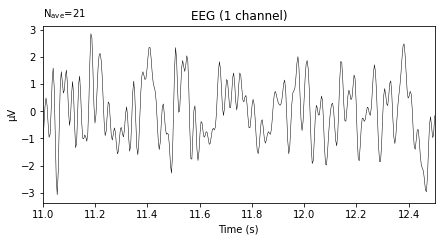

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


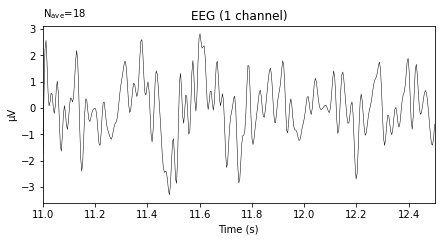

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


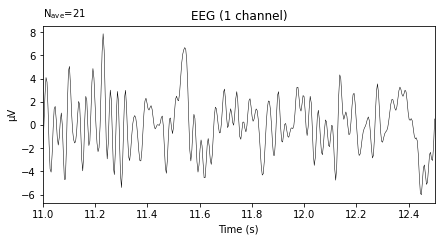

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


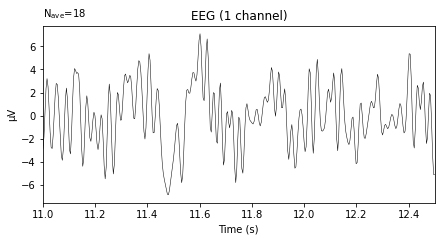

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


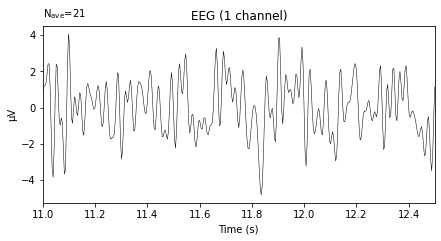

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


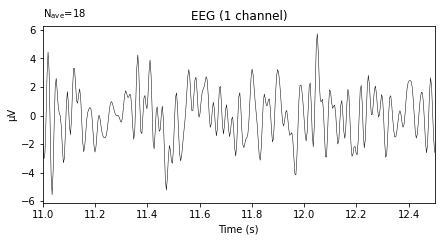

Processing: S20M1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

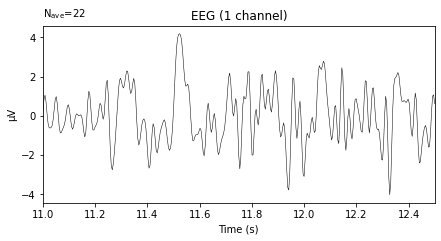

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


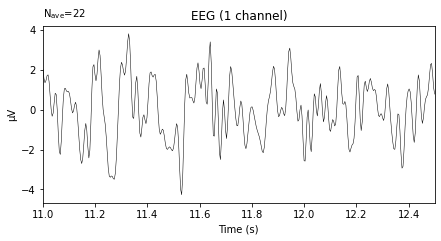

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


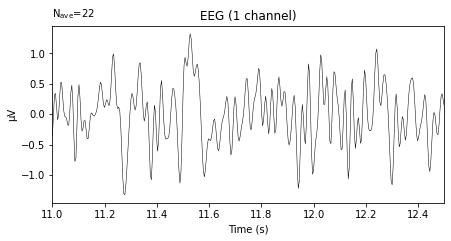

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


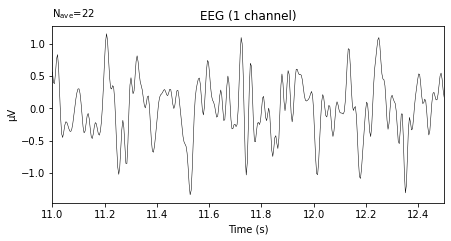

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


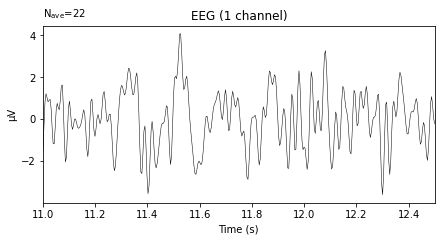

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


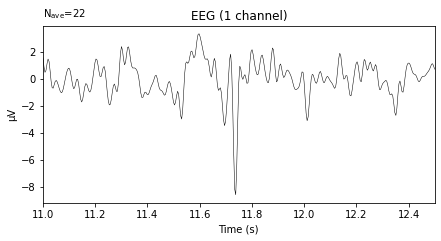

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


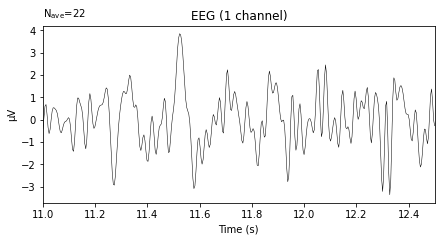

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


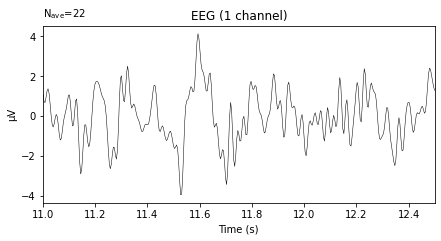

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


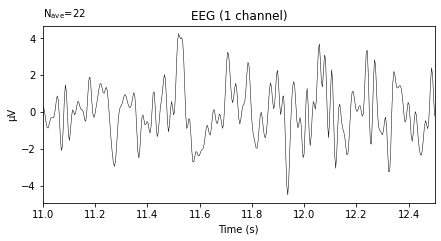

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


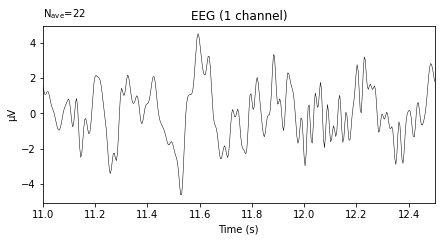

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


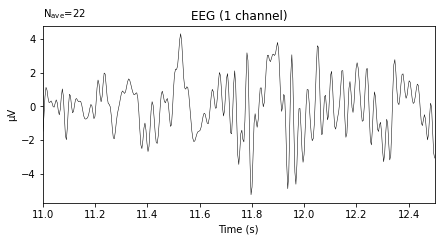

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


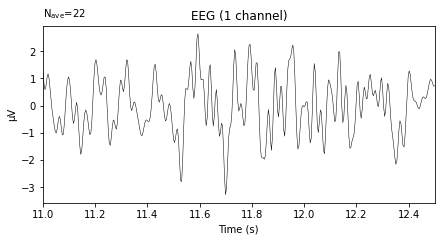

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


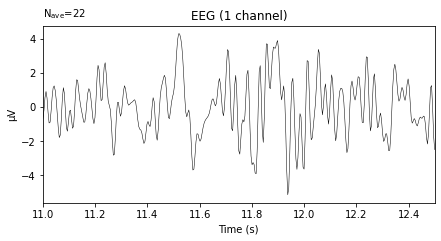

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


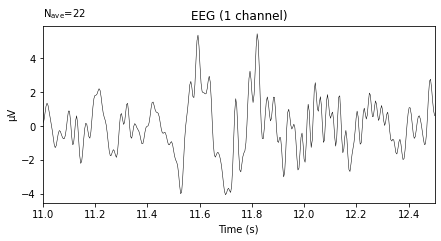

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


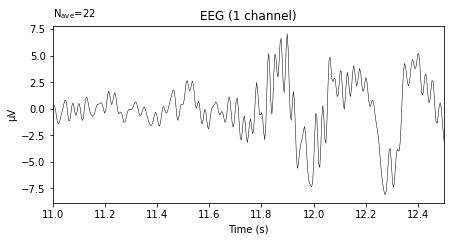

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


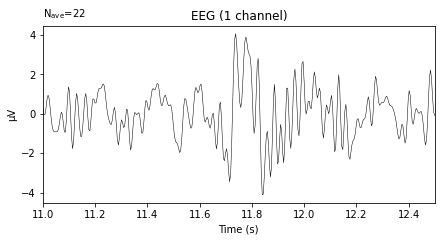

Processing: S21F1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
576 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
576 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

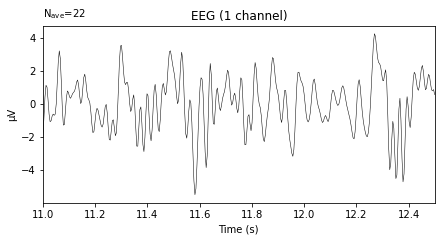

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


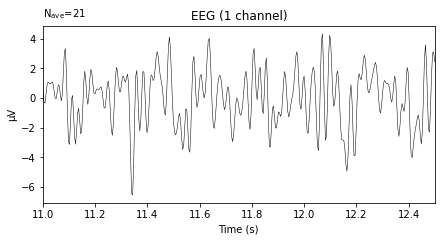

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


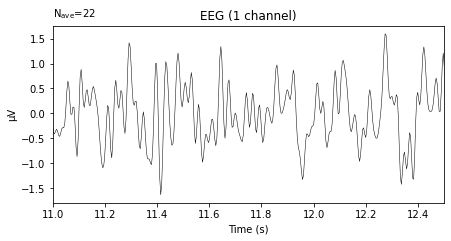

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


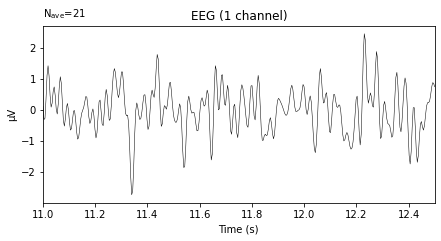

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


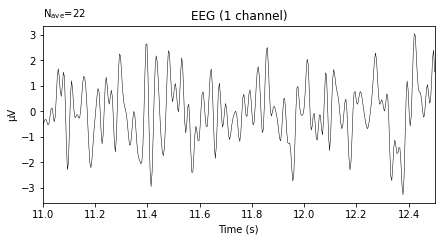

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


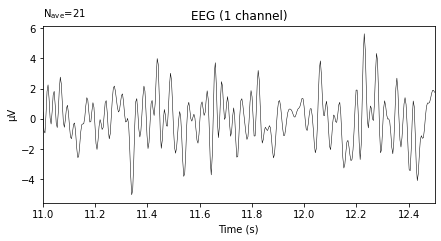

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


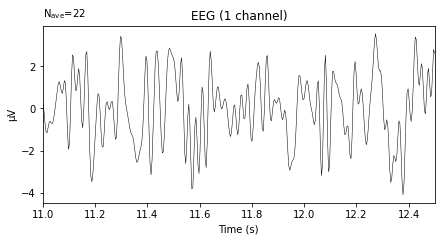

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


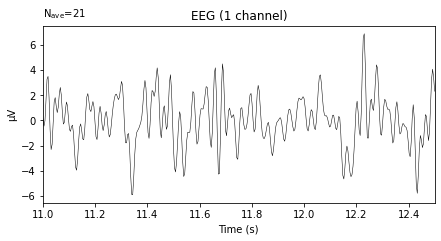

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


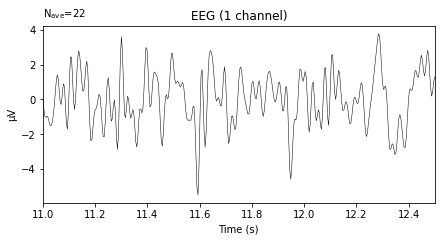

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


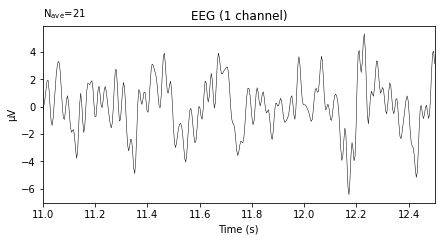

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


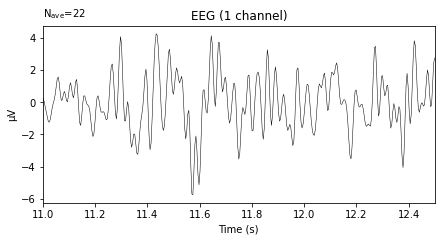

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


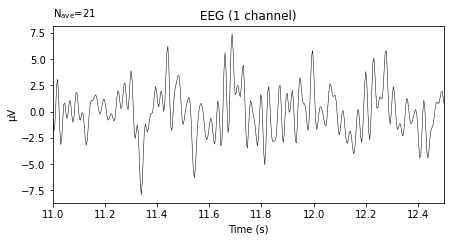

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


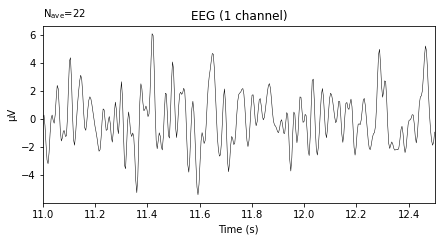

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


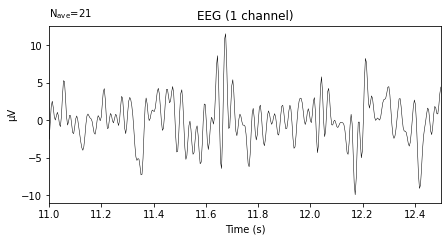

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


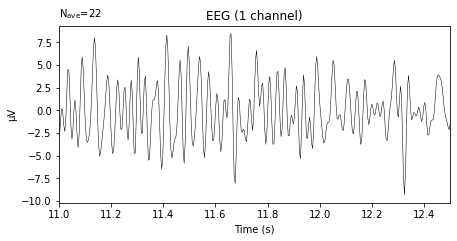

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


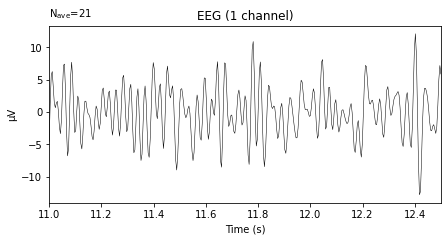

Processing: T11F1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

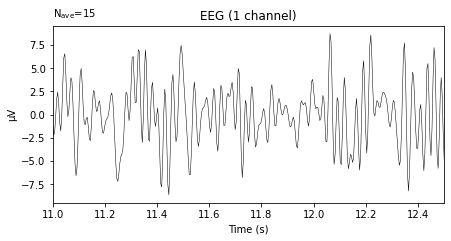

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


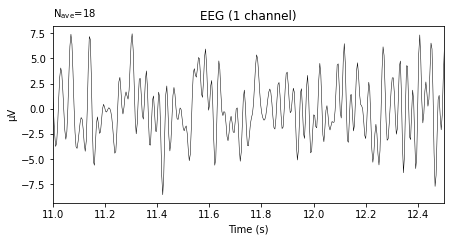

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


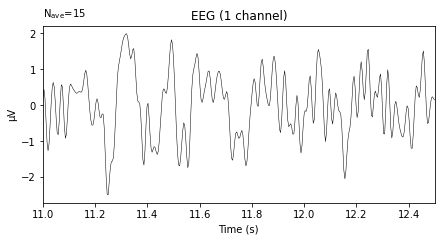

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


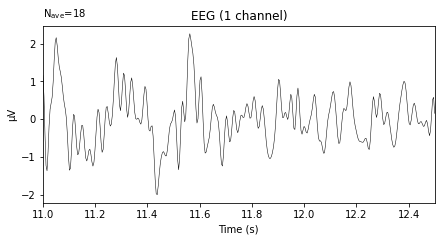

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


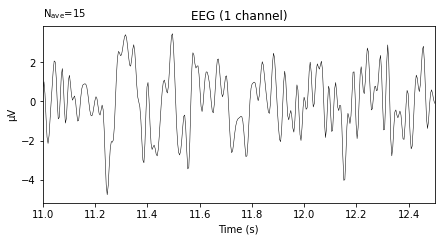

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


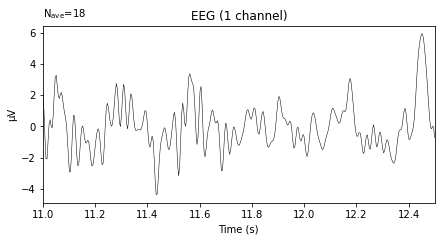

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


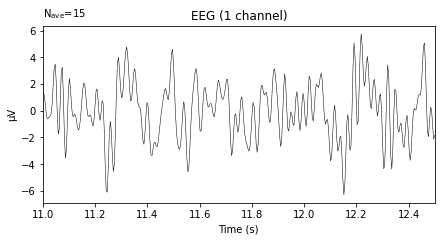

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


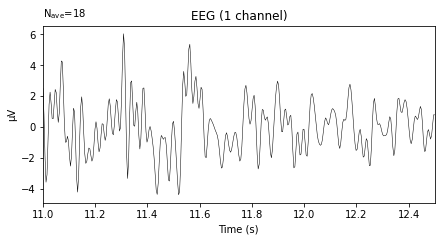

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


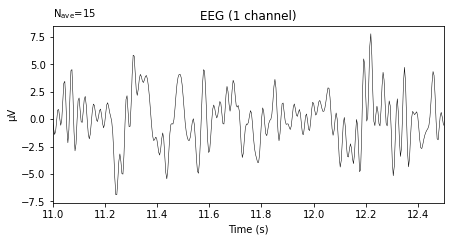

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


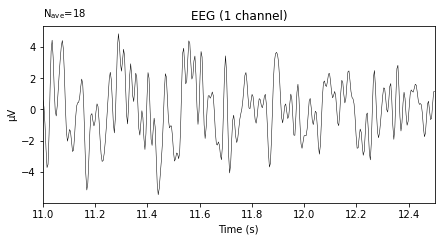

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


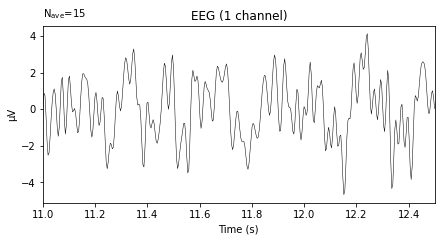

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


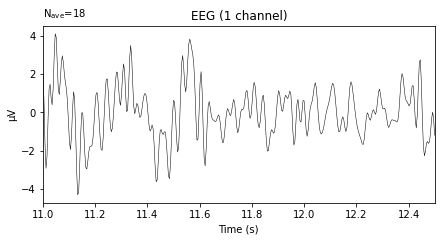

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


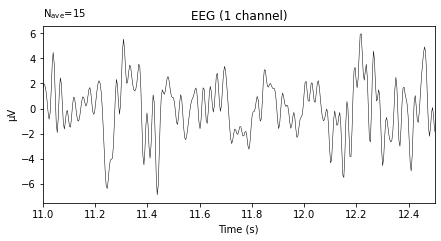

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


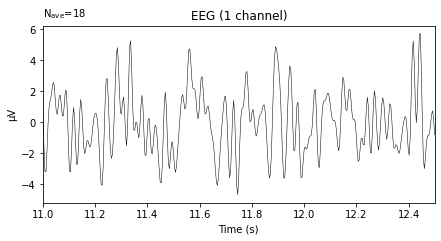

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


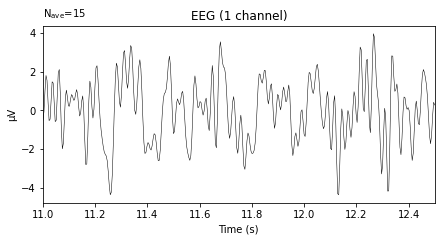

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


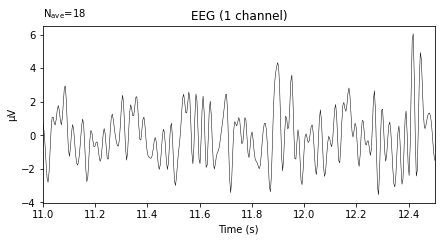

Processing: T16F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

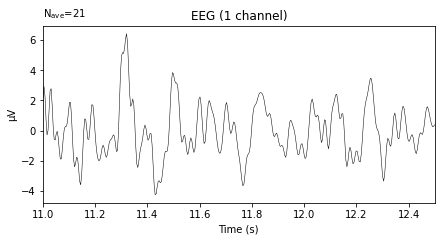

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


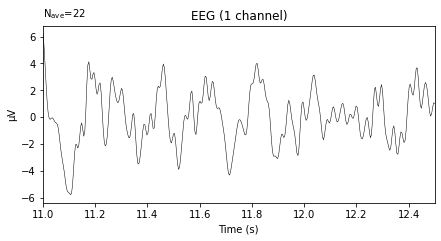

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


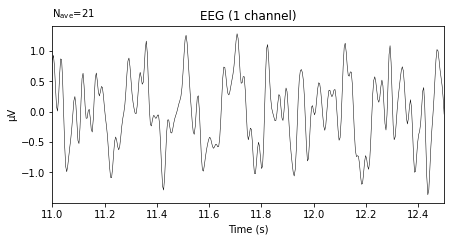

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


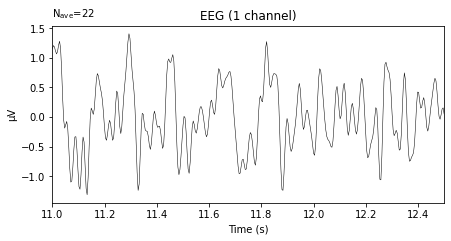

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


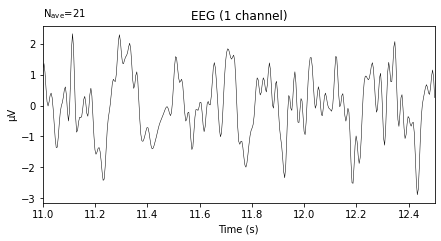

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


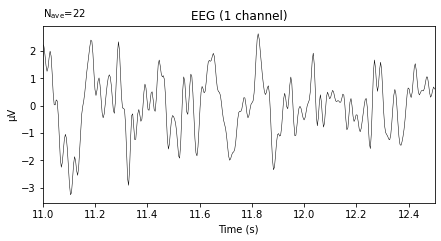

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


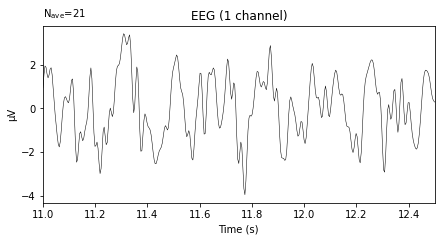

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


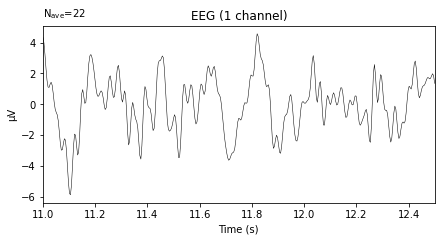

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


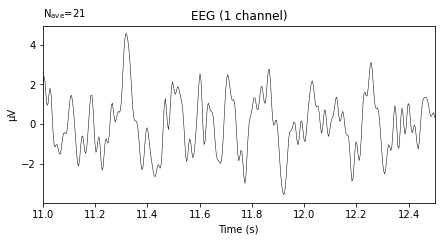

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


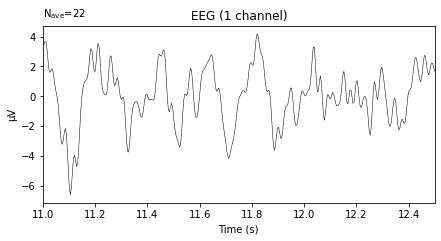

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


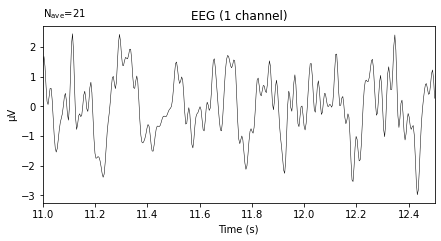

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


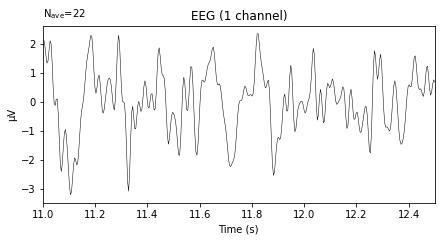

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


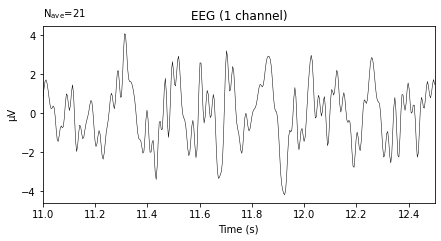

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


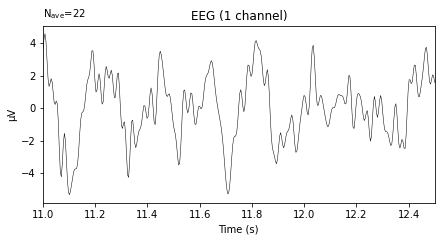

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


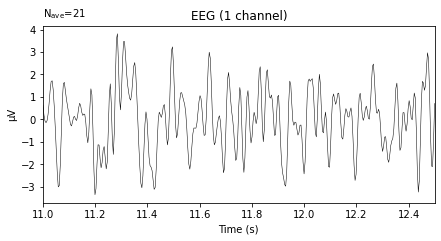

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


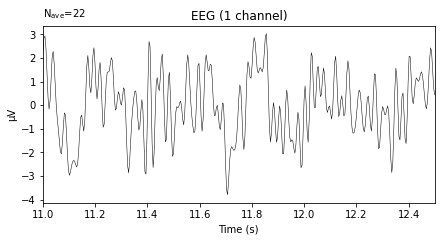

Processing: T18F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

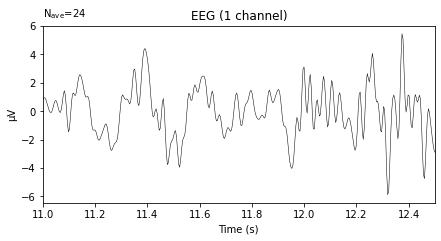

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


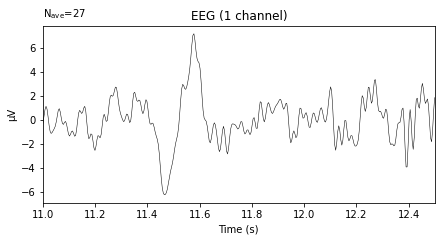

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


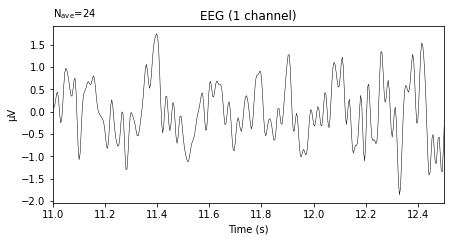

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


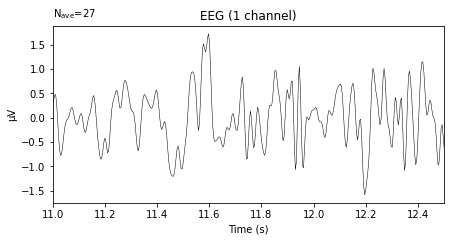

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


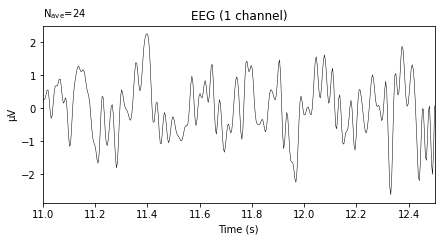

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


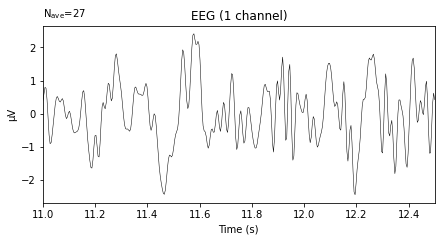

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


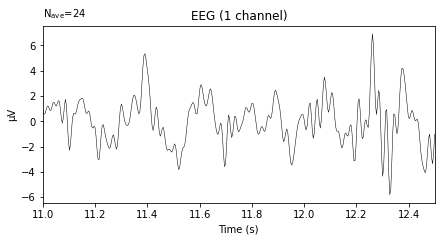

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


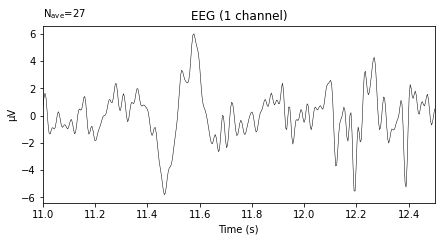

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


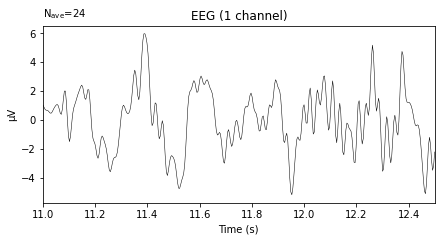

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


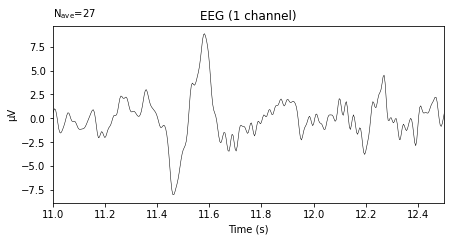

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


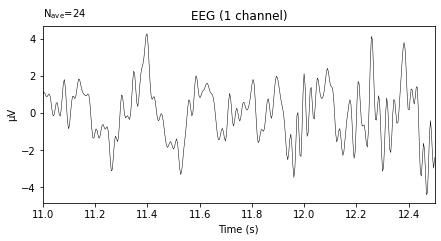

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


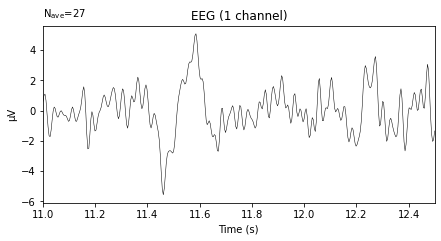

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


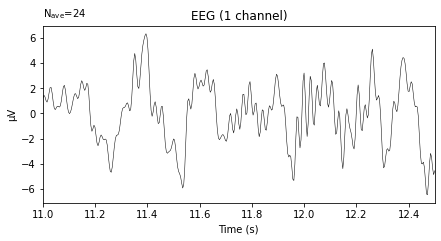

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


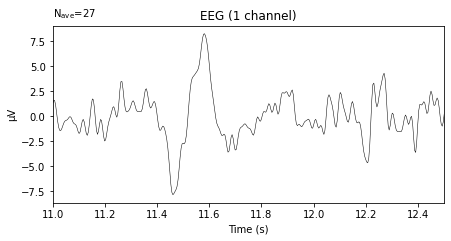

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


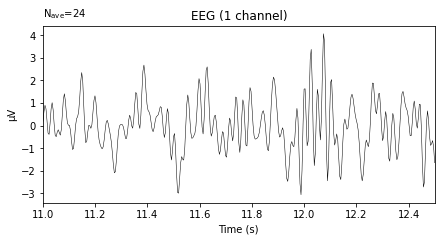

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


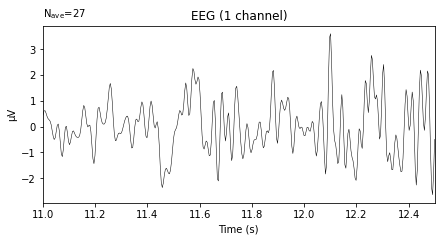

Processing: T18M1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

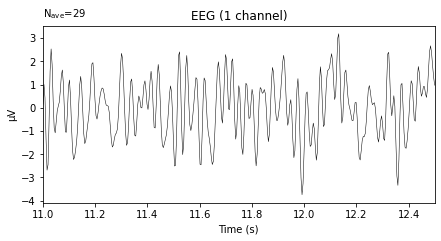

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


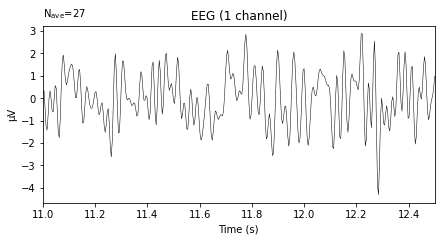

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


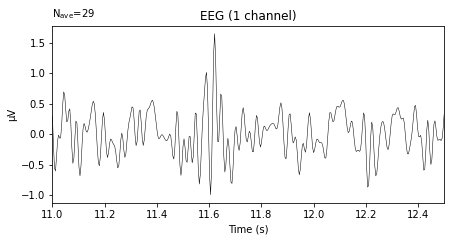

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


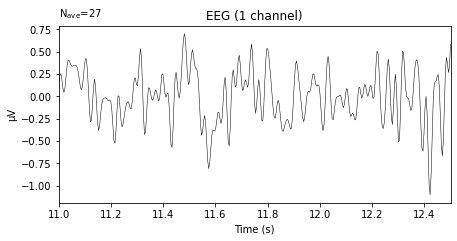

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


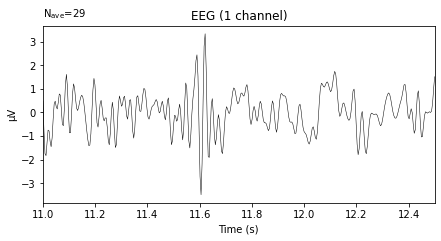

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


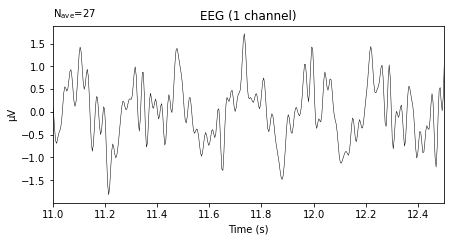

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


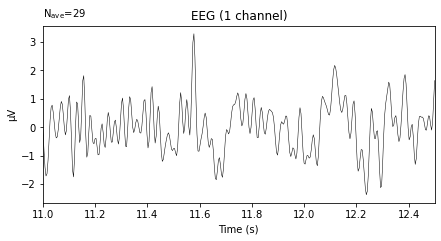

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


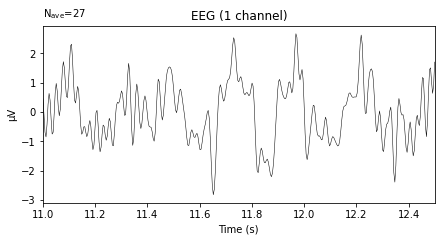

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


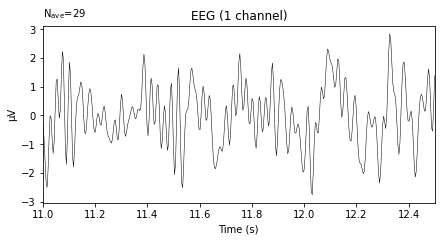

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


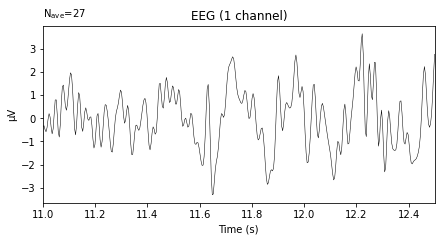

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


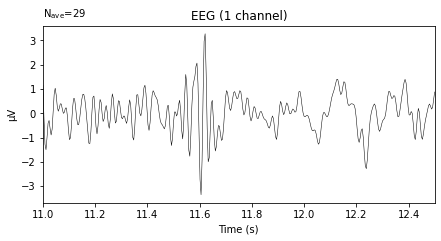

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


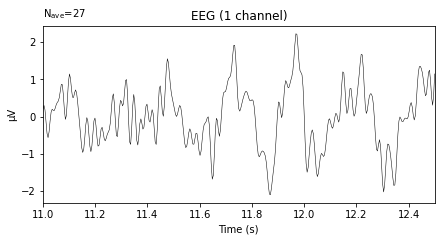

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


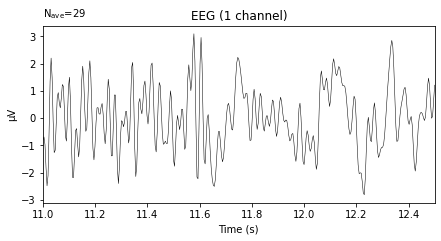

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


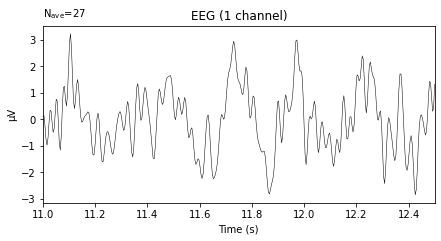

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


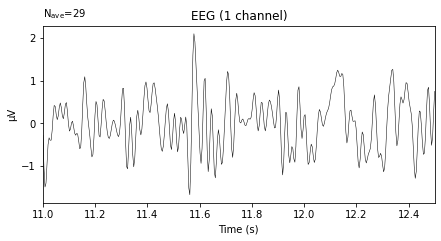

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


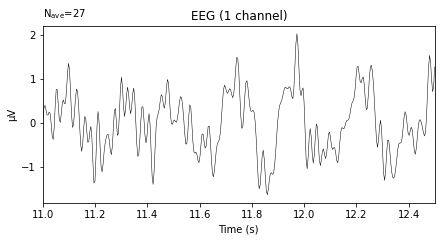

Processing: T23F1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (1.652 sec)

516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Not setting metadata
84 matching events found
Setting baseline interval to [11.0, 12.5] sec
Applying baseline

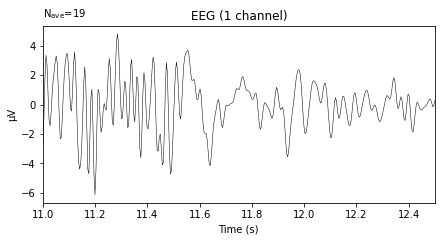

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


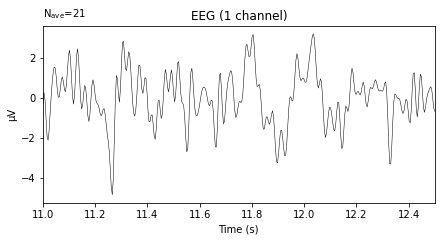

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


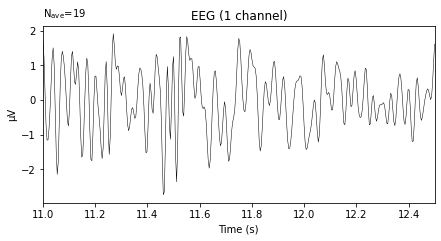

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


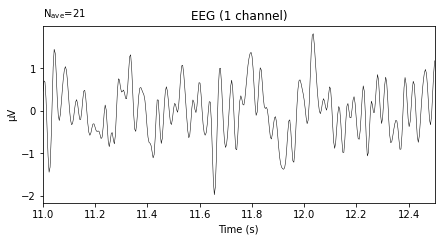

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


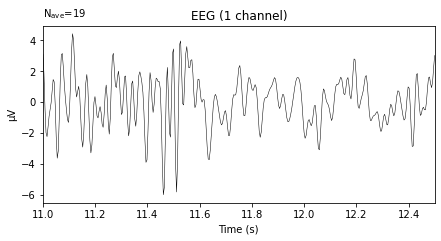

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


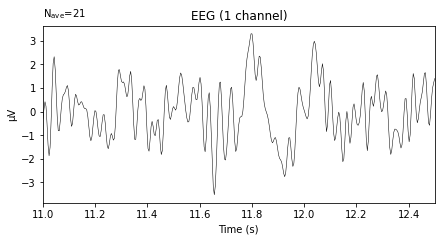

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


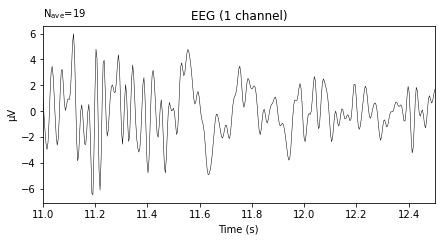

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


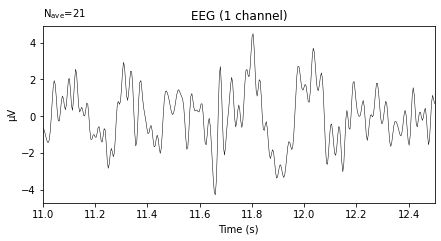

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


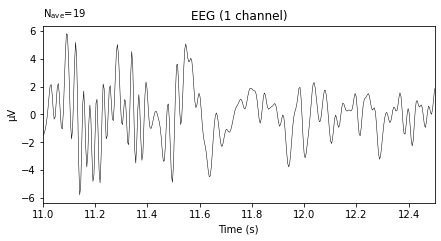

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


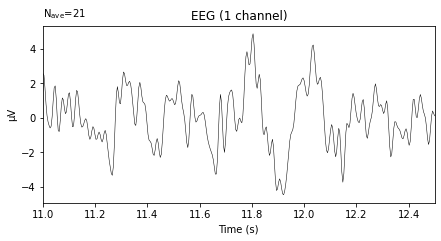

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


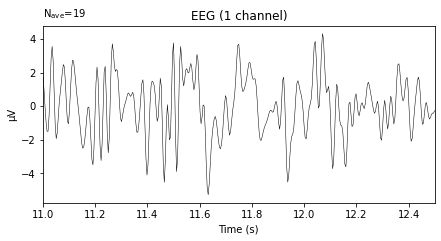

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


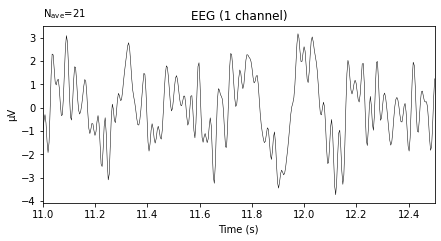

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


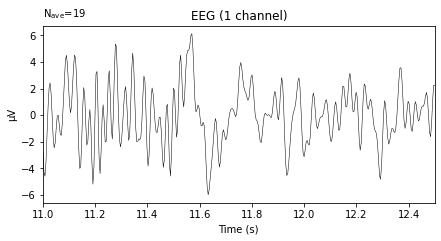

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


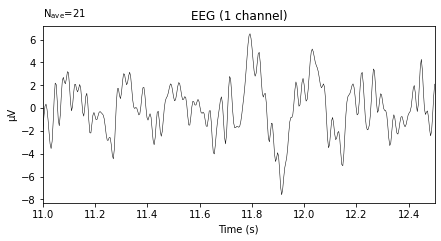

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


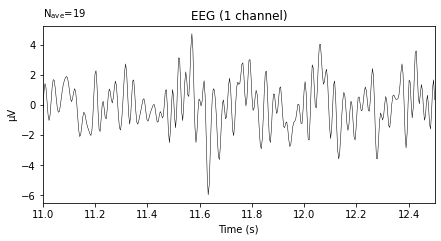

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


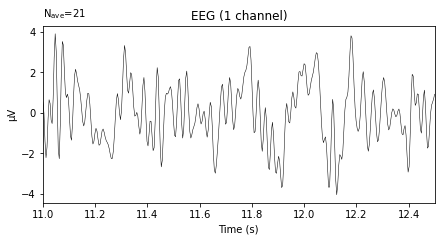

Processing: T23F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

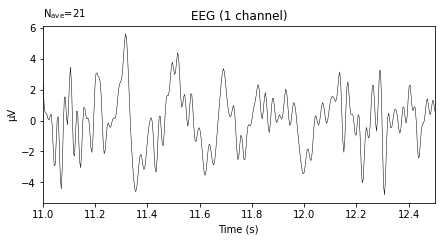

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


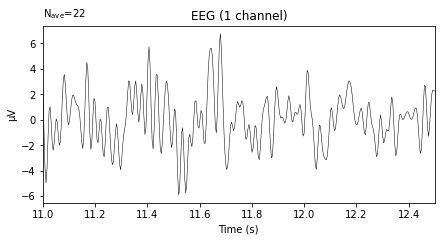

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


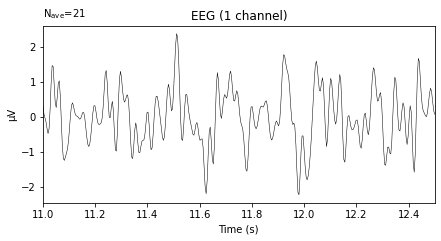

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


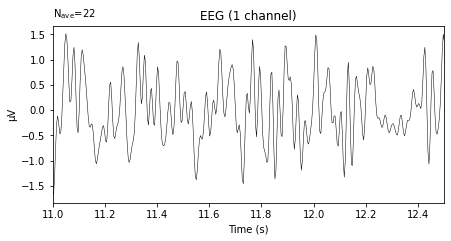

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


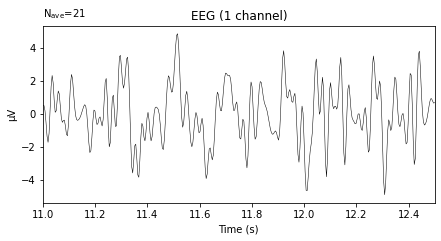

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


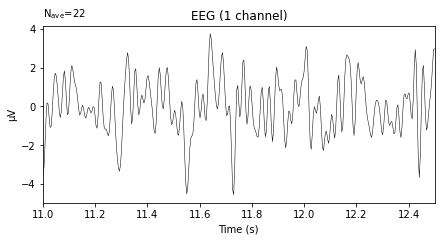

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


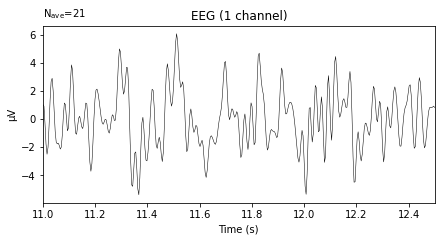

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


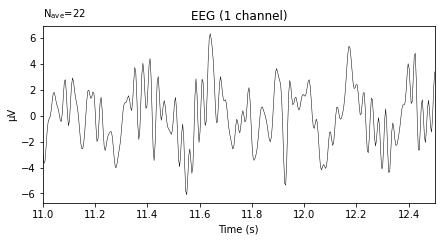

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


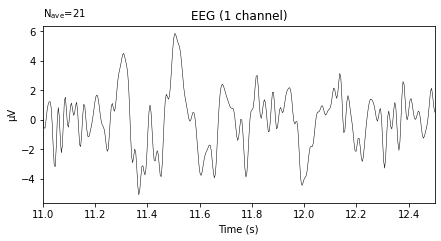

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


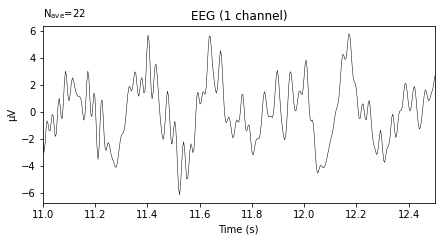

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


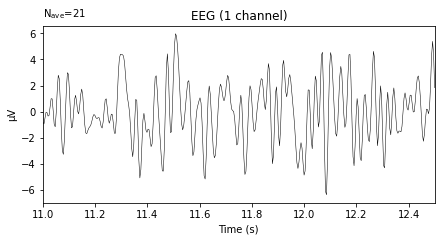

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


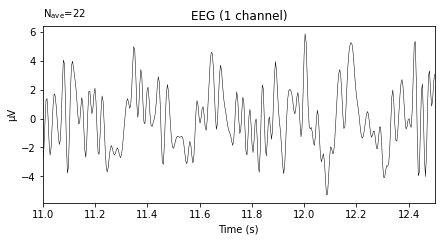

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


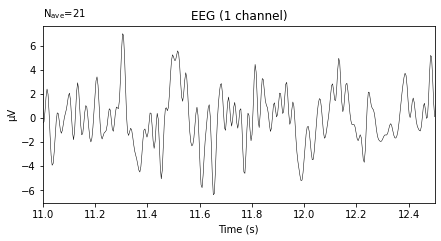

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


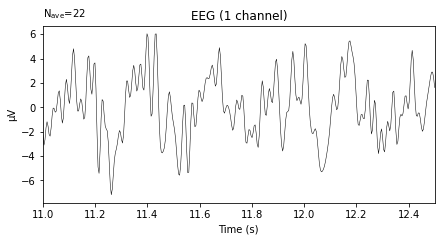

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


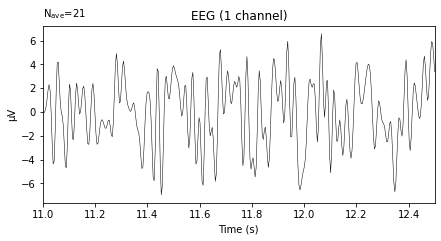

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


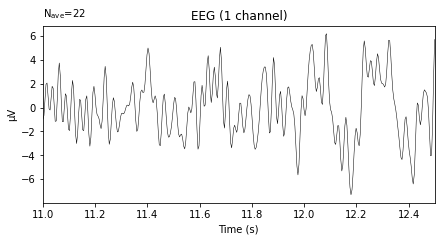

Processing: T25F1.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

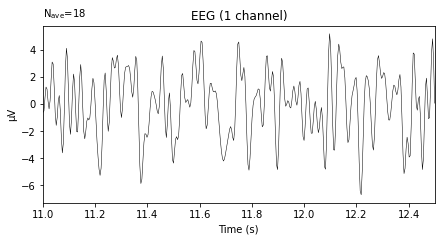

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


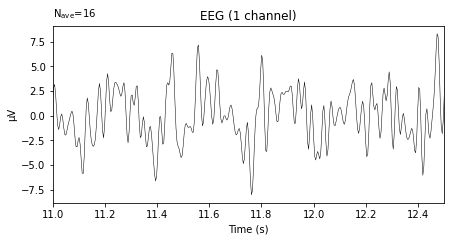

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


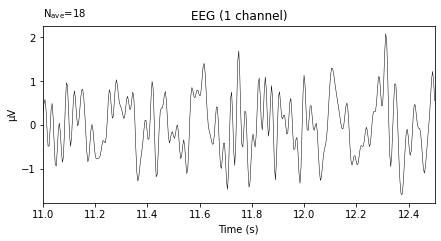

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


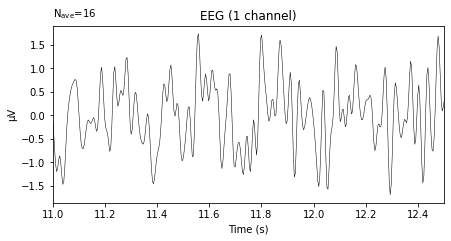

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


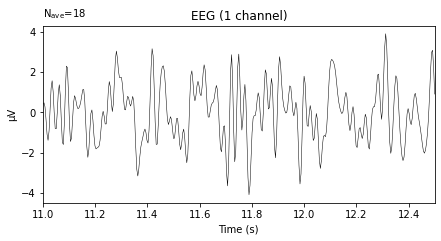

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


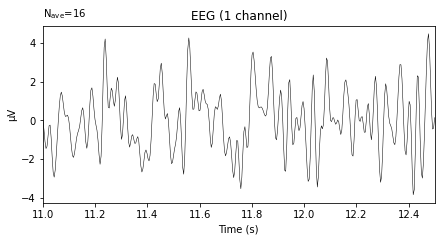

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


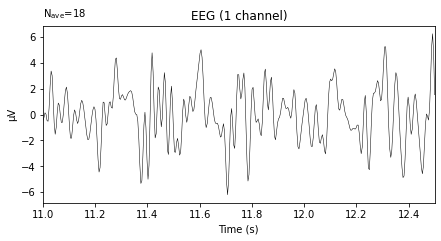

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


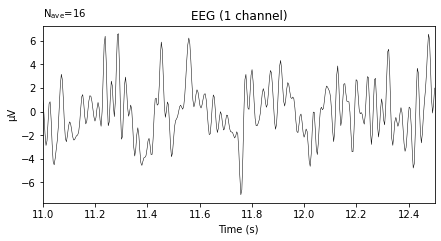

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


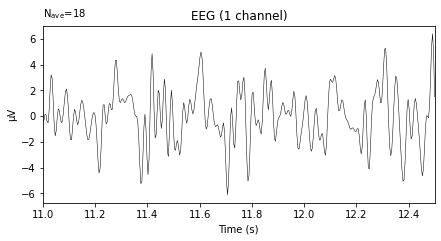

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


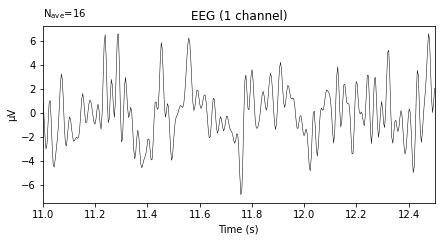

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


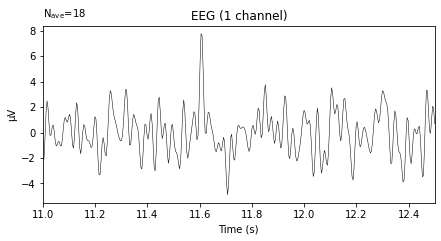

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


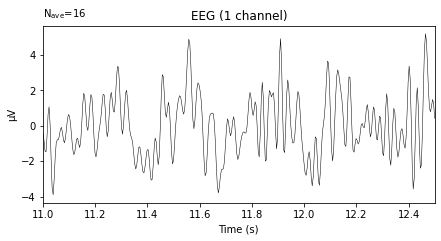

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


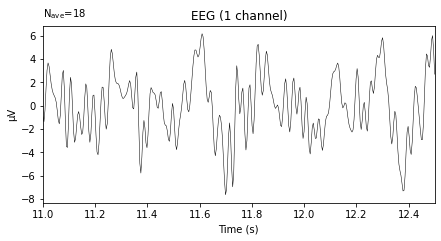

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


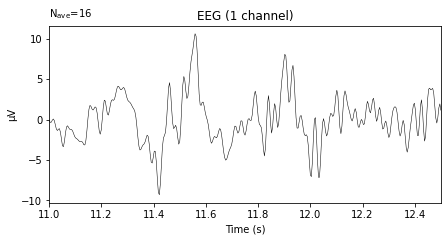

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


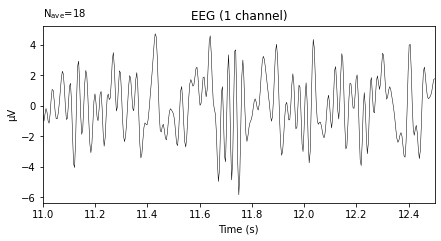

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


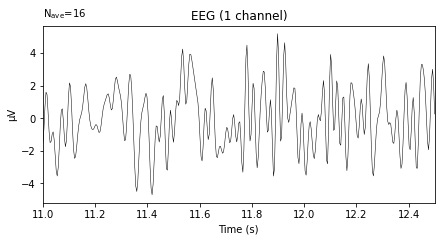

Processing: T9F2_B1-B2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
517 events found
Event IDs: [    1     2     4     8    16    32 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
517 events found
Event IDs: [    1     2     4     8    16    32 65536]
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00

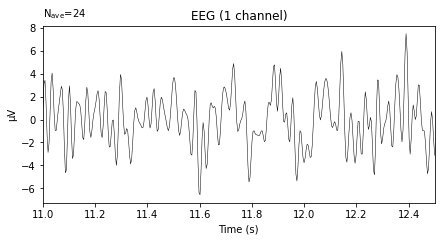

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


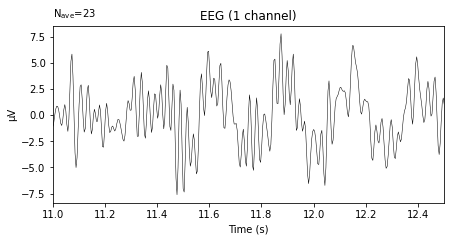

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


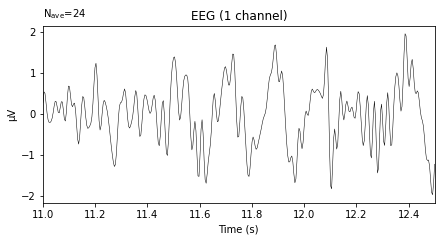

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


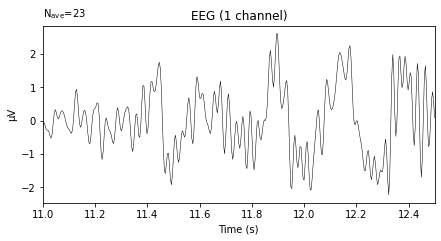

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


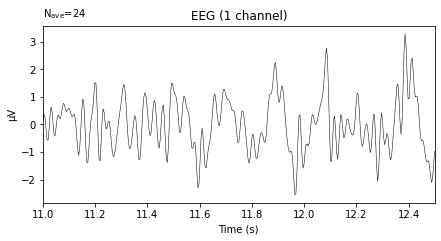

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


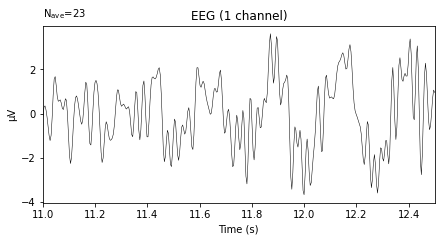

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


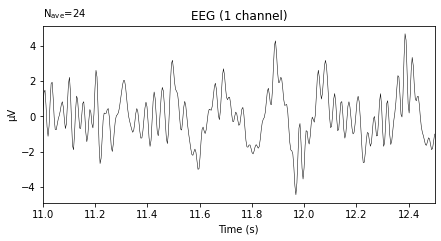

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


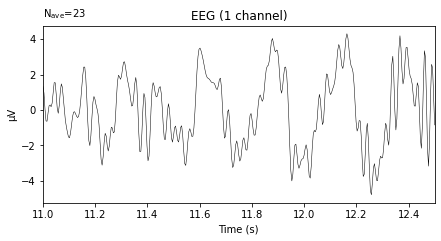

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


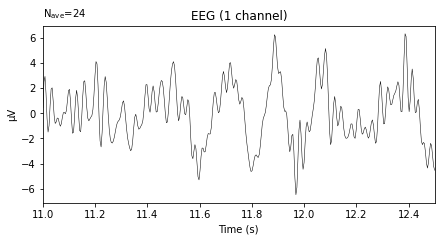

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


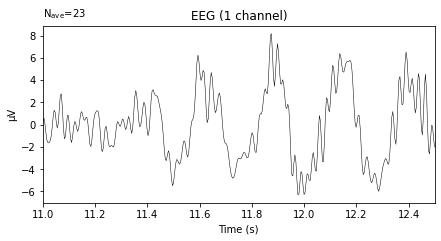

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


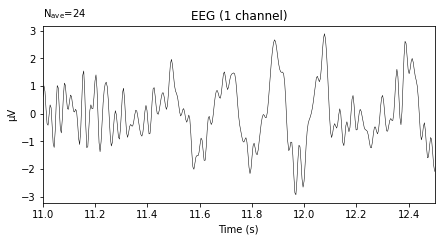

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


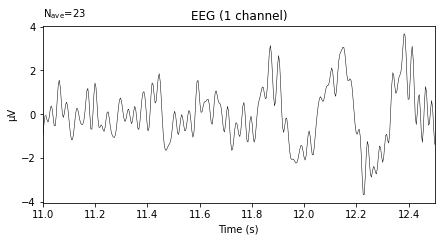

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


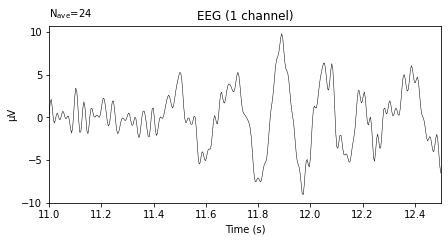

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


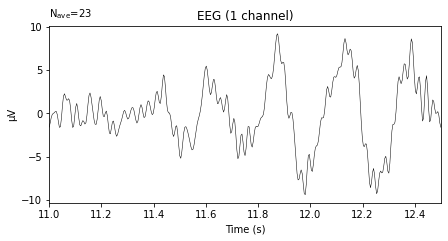

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


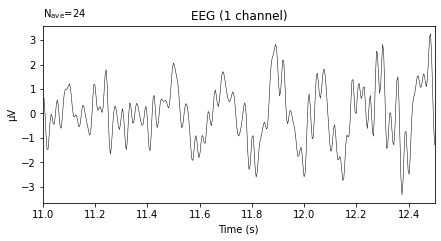

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


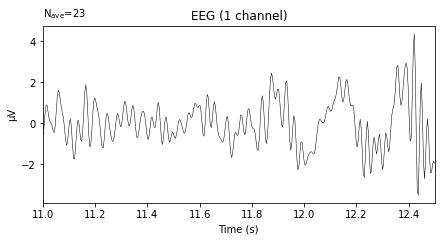

Processing: W10F2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transitio

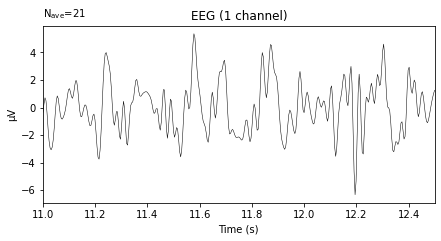

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


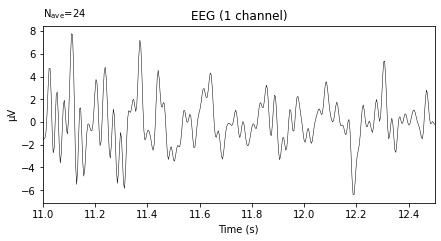

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


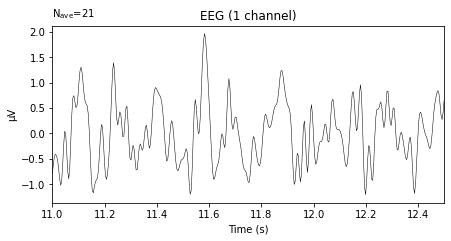

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


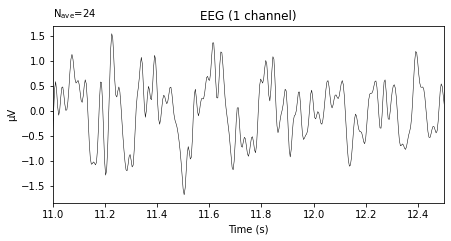

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


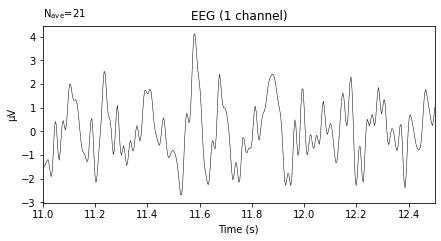

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


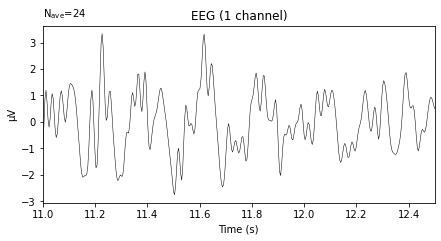

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


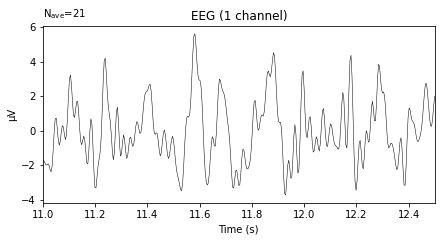

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


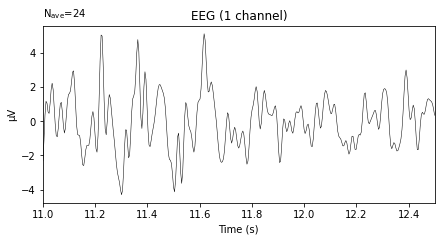

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


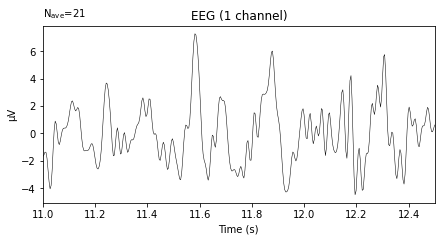

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


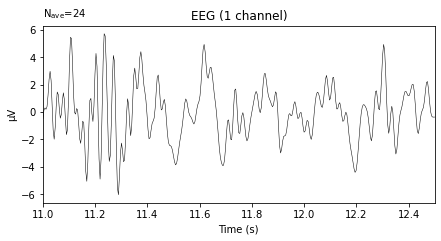

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


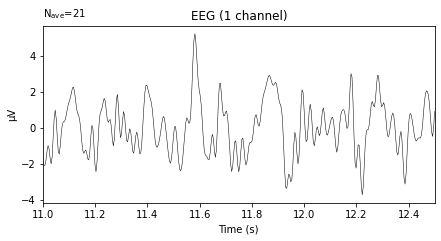

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


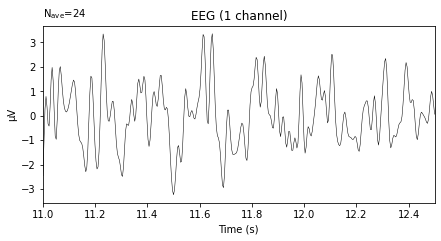

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


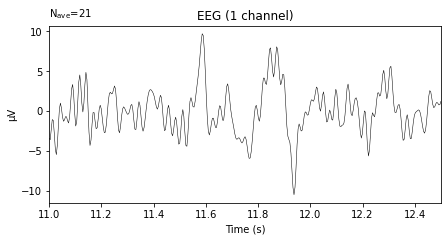

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


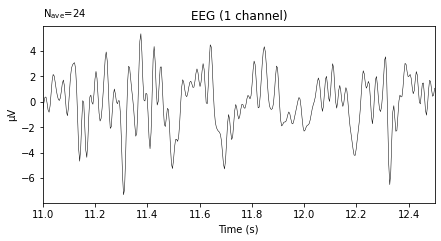

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


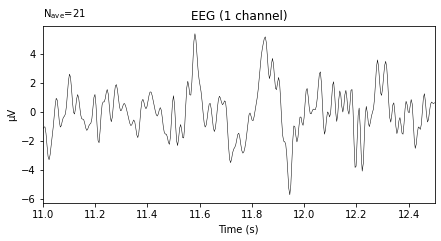

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


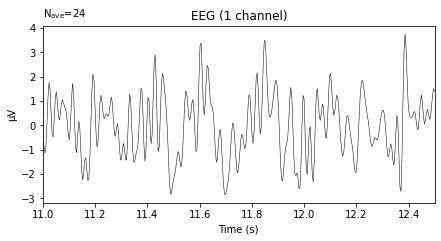

Processing: W17M2.bdf...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
513 events found
Event IDs: [    1     2     4     8    16    32 65540]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
513 events found
Event IDs: [    1     2     4     8    16    32 65540]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Fil

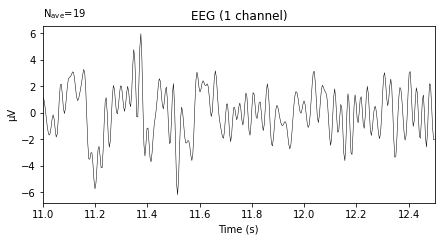

FT7-FT8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


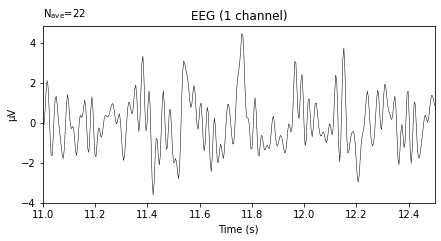

F1-F2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


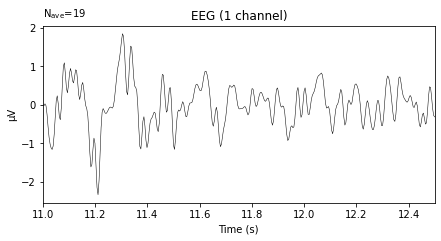

F1-F2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


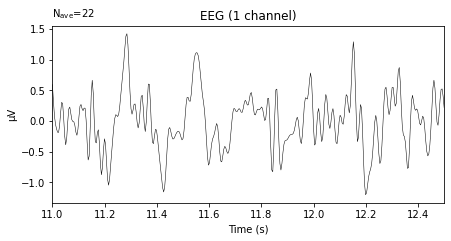

F3-F4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


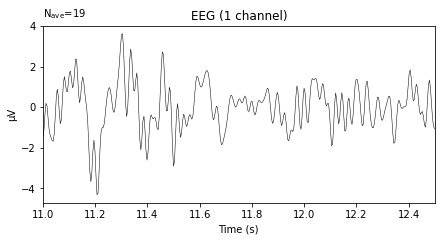

F3-F4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


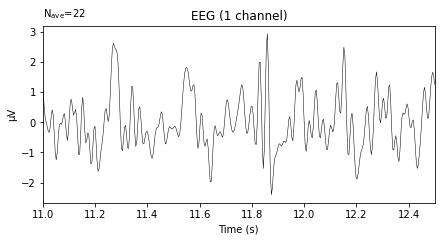

F5-F6 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


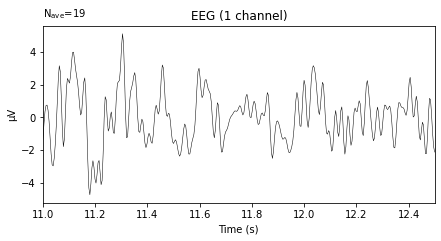

F5-F6 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


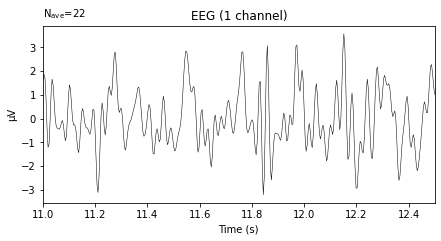

F7-F8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


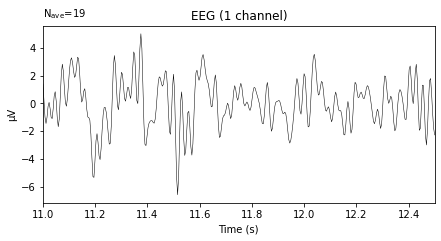

F7-F8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


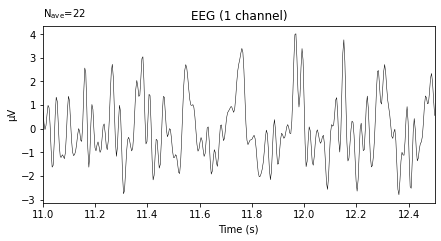

AF3-AF4 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


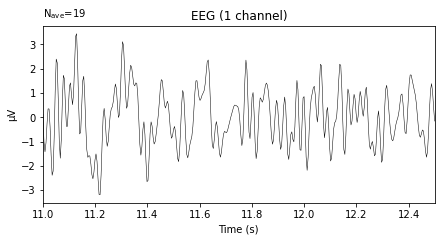

AF3-AF4 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


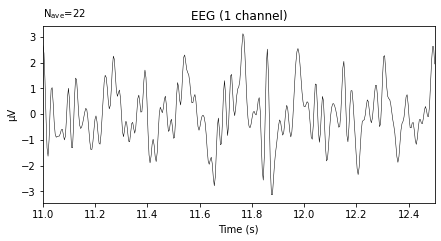

AF7-AF8 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


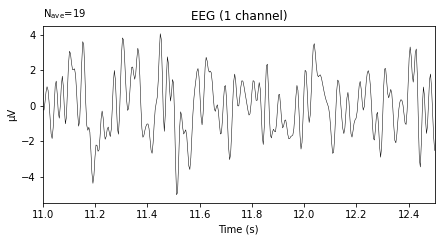

AF7-AF8 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


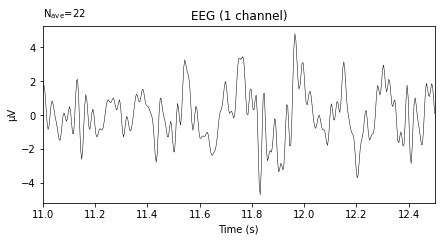

Fp1-Fp2 - right
Need more than one channel to make topography for eeg. Disabling interactivity.


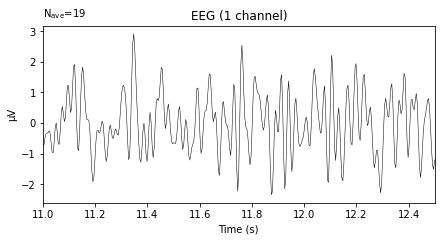

Fp1-Fp2 - left
Need more than one channel to make topography for eeg. Disabling interactivity.


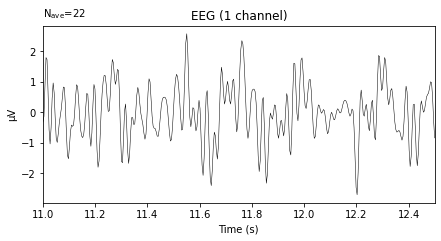

In [5]:
import glob

#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['AFz', 'Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz', 'Iz']
chan_others = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

# ML Channels
ml_chan_left_all = [ch for ch in chan_left_all if ch in clusters_chs['Frontal']]
ml_chan_right_all = [ch for ch in chan_right_all if ch in clusters_chs['Frontal']]
ml_ch_pairs = []
for l,r in zip(ml_chan_left_all, ml_chan_right_all):
    ml_ch_pairs.append(f'{l}-{r}')
        
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\_MOT_BCI_\\src\\'
directory_data = 'D:\\PhD\\_MOT_BCI_\\data - raw\\'
directory_preproc = 'D:\\PhD\\_MOT_BCI_\\data - preprocessed\\'

#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
evoked_dict = dict()
evoked_dict['left'] = dict()
evoked_dict['right'] = dict()
for ch_pair in ml_ch_pairs:
    evoked_dict['left'][ch_pair] = []
    evoked_dict['right'][ch_pair] = []

sep = '\\'
#filepath = directory_data + 'W10F2.bdf'#'T25F1.bdf' #'F12F2.bdf' #'T25F1.bdf'
for filepath in glob.iglob(directory_data + '*.bdf'):
    filename = filepath[filepath.rfind(sep)+1:]
        
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True, verbose=False)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M1_B3.bdf', preload=True, verbose=False)
            raw3 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M1_B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M2_B3.bdf', preload=True, verbose=False)
            raw3 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M2_B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'T9F2_B3-B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'T9M1_B3-B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'        
    
    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Downsampling
    raw.resample(256)
    # Filter
    raw = raw.filter(4, 40)

    # Sampling Frequency
    sfreq = raw.info['sfreq']

    # Events 
    events = find_events(raw)

    # Load Behav Data.
    df_behav = pd.read_csv(directory_data + filename[:filename.rfind('.')] + '.csv', sep=',')

    # Rework Events based on Behav Data. (to add Side and SetSize information)
    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            #if (nb_trials + 1) % 10 == 0:
                #print('Check Synch!')

    # Working with modified events from now on.
    events = new_events

    # Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
    print('==================================================')
    print('Removing Events ID not in EEG File...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events)[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================') 
    
    # Epoching
    epochs = Epochs(raw, events, event_id=cur_event_id, tmin=11, tmax=12.5, picks='eeg', baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')
    epochs_bipolar = mne.set_bipolar_reference(epochs, anode=ml_chan_left_all, cathode=ml_chan_right_all, verbose=False)
    #epochs_id = epochs_bipolar.copy().crop(tmin=0.15, tmax=1.15)

    epochs_bipolar = epochs_bipolar.pick_channels(ml_ch_pairs)

    for ch_pair in epochs_bipolar.ch_names:
        cur_evoked = epochs_bipolar['right/good'].copy().pick_channels([ch_pair]).average()
        evoked_dict['right'][ch_pair].append(cur_evoked)
        print(ch_pair + ' - right')
        x = cur_evoked.plot()
        
        cur_evoked = epochs_bipolar['left/good'].copy().pick_channels([ch_pair]).average()
        evoked_dict['left'][ch_pair].append(cur_evoked)
        print(ch_pair + ' - left')
        x = cur_evoked.plot()

In [7]:
import pickle

with open('ml_evoked_dict.pkl', 'wb') as f:
    pickle.dump(evoked_dict, f)

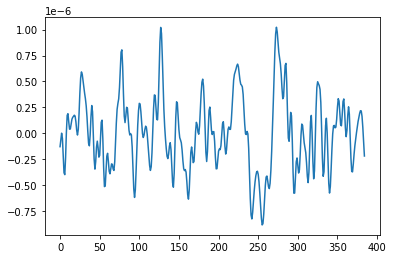

In [20]:
evoked_stack = []
for ch_pair in evoked_dict['right'].keys():
    for cur_evoked in evoked_dict['right'][ch_pair]:
        evoked_stack.append(cur_evoked.get_data())

evoked_mean = np.mean(np.stack(evoked_stack), 0).squeeze()

plt.plot(evoked_mean)

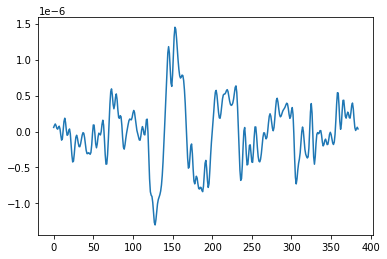

In [21]:
evoked_stack = []
for ch_pair in evoked_dict['left'].keys():
    for cur_evoked in evoked_dict['left'][ch_pair]:
        evoked_stack.append(cur_evoked.get_data())

evoked_mean = np.mean(np.stack(evoked_stack), 0).squeeze()

plt.plot(evoked_mean)